### project specification
 people order food on a online e-commerce platform. drivers take food from restaurant(placeId) to the customer (delivery city and delivery detail)
target: predicts the time from placing an order to order completation.
 ### approaches
 #### feature analysis and engineer
 - barplot, violinplot, boxplot for category vs numeric relation study
 - heatmap for category,category vs numeric relation study
 - kdeplot, histplot for distribution study
 - statistics by group by operation to give more detail information
 - openfe tool for more feature space searching 
 #### model study
 5 model were studied.
 model name | platform | score (rmse)
 -----------|----------|------------
 xgboost   | sklearn  |10.682, 10.60(by openfe augment)
lightgbm   | sklearn  |9.925
tabnet    | torch    |10.338
ft transformer| torch  |13.36
resnet    | tensorflow|10.23
#### end to end model
feature engineering by sklearn pipeline and end to end model was produced.
### conclusion
+ lightgbm is the best， tabnet and tesnet are also powerful
+ statistics by group by operation make a good performance improvement.
+ open fe tool make improvement to xgboost, but no improvement to other model.
+ pretraining have better performance on tabnet
+ ft transformer is not fit for such a problem

In [475]:
import pandas as pd
import math
import numpy as np
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import re
import datetime

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer,OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.base import BaseEstimator,MetaEstimatorMixin

from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics


from lightgbm.sklearn import LGBMRegressor,LGBMClassifier
import lightgbm
from xgboost.sklearn import XGBClassifier,XGBRegressor

import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
warnings.filterwarnings("ignore")


### delivery time is made up of 3 parts:
- products prepare time
- wait time before delivery
- delivery time

In [438]:

# 从JSON文件中读取数据
file_path = 'orders_big_ob.json'
ori_frame = pd.read_json(file_path)



data= ori_frame.copy()
data[data.columns] = SimpleImputer(strategy="constant").fit_transform(data[data.columns] )

data = data[["placeId","deliveryCityId","deliveryDetails","placeLaLn","deliveryLaLn","deliveryDistanceKm"
           ,"routeEstTravelTime","afoodDelivery","created","acceptedDelivery"
           ,"delivering","completed","driverUid","placeCompanyId"
          ,"driverPaysOnPickup","products","noobCustomer","hadFeedback"]]
data["deliver_duration"] = (data.completed-data.delivering)/(1000*60)
data["prepare_duration"] = (data.acceptedDelivery-data.created)/(1000*60)
data["wait_gap"] = (data.delivering-data.acceptedDelivery)/(1000*60)
data["total_duration_min"] = (data.completed-data.created)/(1000*60)
data = data.query("completed>0  and deliveryDistanceKm!=0 and total_duration_min<70.0 and total_duration_min>10 and wait_gap>0 and deliver_duration>0 ")
data["deliver_speed"] = data.deliveryDistanceKm/data.deliver_duration
data.reset_index(drop=True,inplace=True)
print(data.shape)

data,test_data = train_test_split(data,test_size=0.2)

(12413, 23)


### features preprocessing
- placeCompanyId
- placeLaLno,deliveryLaLn

In [439]:
pipe = Pipeline(steps=[])

## for duplication
def add_step(self,name,transformer):
    names = [n for n,_ in self.steps]
    if(name not in names):
        self.steps.append((name,transformer))
Pipeline.add_step=add_step

def threshold_func(d,name,stat,threshold):
    d[name]= d[name].apply(lambda x: x if(stat.get(x,0)>threshold) else "rare")
    return d

stat = data["placeCompanyId"].value_counts().to_dict()
placeCompanyTrans = FunctionTransformer(threshold_func,kw_args={"name":"placeCompanyId","stat":stat,"threshold":20})
pipe.add_step("com",placeCompanyTrans)
data = placeCompanyTrans.transform(data)


def split_number(d,name,out):
    def f(s):
        result = [0,0]
        if(pd.isna(s)==False):
            splits = s.split(",")
            if(len(splits)==2):
                result = [float(x) for x in splits]
        return pd.Series(result)
    d[out]=d[name].apply(f)
    return d

placelaLn = FunctionTransformer(split_number,kw_args={"name":"placeLaLn","out":["placeLa","placeLn"]})
data = placelaLn.transform(data)
deliveryLaLn =  FunctionTransformer(split_number,kw_args={"name":"deliveryLaLn","out":["deliveryLa","deliveryLn"]})
data = deliveryLaLn.transform(data)

pipe.add_step("placelaln",placelaLn)
pipe.add_step("deliveryLaLn",deliveryLaLn)
data = pipe.transform(data)
data

,placeId,deliveryCityId,deliveryDetails,placeLaLn,deliveryLaLn,deliveryDistanceKm,routeEstTravelTime,afoodDelivery,created,acceptedDelivery,...,hadFeedback,deliver_duration,prepare_duration,wait_gap,total_duration_min,deliver_speed,placeLa,placeLn,deliveryLa,deliveryLn
0,laParc,chiajna,primarie contabilitate,"44.456306, 25.977077","44.46063,25.977156",2.6,1.5,True,1701080293822,1701081094978,...,False,10.149633,13.352600,0.174233,23.676467,0.256167,44.456306,25.977077,44.460630,25.977156
1,clatiteBolintin,bolintin_deal,Strada Dispensarului 3,"44.446605, 25.756946","44.452501,25.824015",5.6,7.3,True,1701079651647,1701080314408,...,False,4.047883,11.046017,22.101483,37.195383,1.383439,44.446605,25.756946,44.452501,25.824015
2,zeina,bolintin_deal,Strada Dispensarului 3,"44.44698515508772, 25.75288086524","44.452501,25.824015",6.5,8.3,True,1701079497666,1701080301077,...,False,3.875367,13.390183,22.395533,39.661083,1.677261,44.446985,25.752881,44.452501,25.824015
3,limatexRestaurant,bolintin_vale,Poarta luncii 91,"44.447887, 25.755343","44.437288,25.763221",2.6,3.1,True,1701079197247,1701080215614,...,False,7.556017,16.972783,11.541583,36.070383,0.344097,44.447887,25.755343,44.437288,25.763221
4,limatexRestaurant,malu_spart,principala nr 581 spre top speed,"44.447887, 25.755343","44.442733,25.715012",4.5,5.3,True,1701078973549,1701079968605,...,False,6.774383,16.584267,23.401933,46.760583,0.664267,44.447887,25.755343,44.442733,25.715012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12408,biteMe,ulmi,Principala 50bis,"44.448800, 25.755594","44.487278,25.781803",8.2,missing_value,True,1683532335182,1683533599472,...,False,0.058367,21.071500,18.190183,39.320050,140.491148,44.448800,25.755594,44.487278,25.781803
12409,biteMe,bolintin_vale,poarta luncii nr 117,"44.448800, 25.755594","44.437288,25.763221",2.6,missing_value,True,1683530690911,1683532207459,...,False,0.111317,25.275800,27.572200,52.959317,23.356790,44.448800,25.755594,44.437288,25.763221
12410,zeina,bolintin_vale,Libertății 179A,"44.44698515508772, 25.752880865222014","44.437288,25.763221",2.6,missing_value,True,1683487727172,1683487861110,...,False,9.086017,2.232300,2.109017,13.427333,0.286154,44.446985,25.752881,44.437288,25.763221
12411,zeina,bolintin_vale,"DJ151E & Strada Republicii, DJ601, DJ401A Ben...","44.44698515508772, 25.752880865222014","44.437288,25.763221",2.6,missing_value,True,1683487725846,1683488112721,...,False,13.108450,6.447917,0.314833,19.871200,0.198345,44.446985,25.752881,44.437288,25.763221


### Data analysis
### la, lo against delivery speed 
3d figure show that some la,lo have low deliver speed

but la,lo have no relation to wait gap and prepare time



0.0    2500
3.0    2500
1.0    2500
2.0    2500
Name: speed_class, dtype: int64


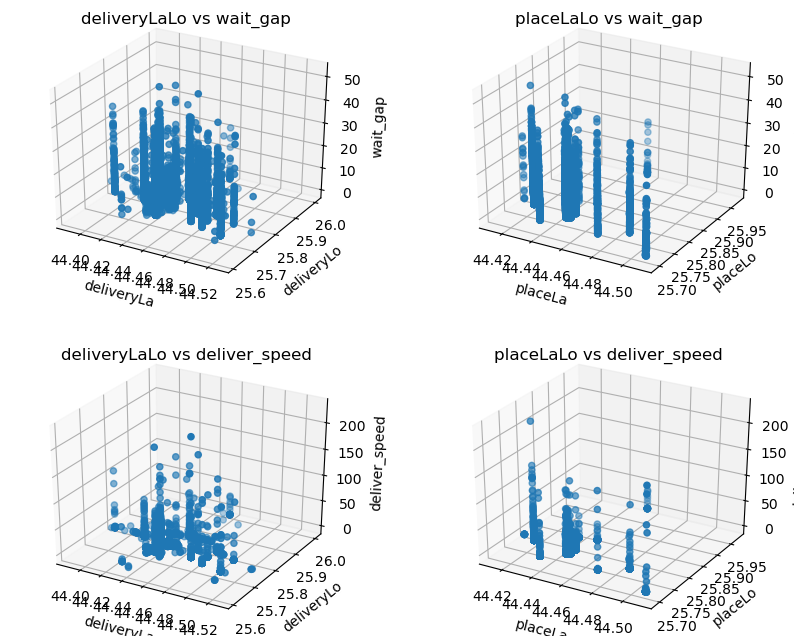

In [323]:
d = data.sample(n=10000)
kb = KBinsDiscretizer(n_bins=4,encode="ordinal",strategy="quantile")
ds = np.reshape(d["deliver_speed"].values,[-1,1])
d["speed_class"] = kb.fit_transform(ds)
print(d["speed_class"].value_counts())

# sns.scatterplot(x="deliveryLa",y="deliveryLo",hue="speed_class",data=d)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221, projection='3d')

ax.scatter(d.deliveryLa, d.deliveryLn, d.wait_gap)
# 设置坐标轴和标题
ax.set_xlabel('deliveryLa')
ax.set_ylabel('deliveryLo')
ax.set_zlabel('wait_gap')
ax.set_title('deliveryLaLo vs wait_gap')

ax = fig.add_subplot(222, projection='3d')
ax.scatter(d.placeLa, d.placeLn, d.wait_gap)

# 设置坐标轴和标题
ax.set_xlabel('placeLa')
ax.set_ylabel('placeLo')
ax.set_zlabel('wait_gap')
ax.set_title('placeLaLo vs wait_gap')

ax = fig.add_subplot(223, projection='3d')
ax.scatter(d.deliveryLa, d.deliveryLn, d.deliver_speed)

# 设置坐标轴和标题
ax.set_xlabel('deliveryLa')
ax.set_ylabel('deliveryLo')
ax.set_zlabel('deliver_speed')
ax.set_title('deliveryLaLo vs deliver_speed')

ax = fig.add_subplot(224, projection='3d')
ax.scatter(d.placeLa, d.placeLn, d.deliver_speed)

# 设置坐标轴和标题
ax.set_xlabel('placeLa')
ax.set_ylabel('placeLo')
ax.set_zlabel('deliver_speed')
ax.set_title('placeLaLo vs deliver_speed')

plt.show()

### where is place and delivery city
placeid are more focused

and delivery city scattered across the map

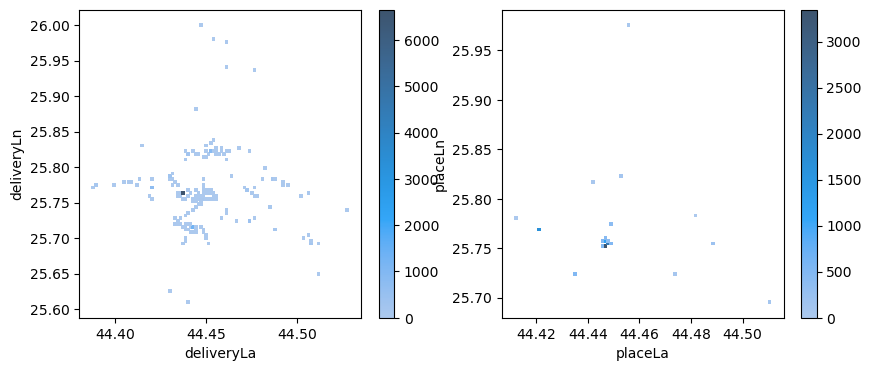

In [207]:

fig,axes = plt.subplots(1,2,figsize=(10,4))
sns.histplot(data=data,x="deliveryLa",y="deliveryLn",stat="count",bins=100,ax=axes[0],cbar =True)#
sns.histplot(data=data,x="placeLa",y="placeLn",stat="count",bins=100,ax=axes[1],cbar =True)

# sns.histplot(data=data,x="deliveryLa",y="deliveryLo",stat="density",bins=(50,50),ax=axes[0],hue="speed_class")
# sns.histplot(data=data,x="placeLa",y="placeLo",stat="density",bins=(50,50),ax=axes[1],hue="speed_class")

### adjust palceId ,delivery city to smaller set
### combination of palceId and deliverycity show very different delivery speed
that's a good feature!!

Pipeline(steps=[('com',
                 FunctionTransformer(func=<function threshold_func at 0x0000016821FED670>,
                                     kw_args={'name': 'placeCompanyId',
                                              'stat': {'': 668, '23253231': 37,
                                                       '34245838': 7,
                                                       '41992313': 121,
                                                       '42879585 ': 1,
                                                       '44215192': 20,
                                                       '45723997': 84,
                                                       '46068071': 212,
                                                       '46425492': 497,
                                                       '46438590': 45,
                                                       '46513241': 402,
                                                       'RO11414180': 1567,
                                                       'RO16738706': 1675,
                                                       'RO17546369': 198,
                                                       'RO28804820': 2...
                                                       'crevedia_mare': 11,
                                                       'crivina': 368,
                                                       'draganeasca': 3,
                                                       'dragomiresti_deal': 2,
                                                       'dragomiresti_vale': 1,
                                                       'floresti': 195,
                                                       'gaiseni': 4,
                                                       'ghionea': 3,
                                                       'hobaia': 144,
                                                       'icoana': 88,
                                                       'indrustrial_deal': 6,
                                                       'malu_spart': 1506,
                                                       'mihai_voda': 283,
                                                       'ogrezeni': 756,
                                                       'palanca': 401,
                                                       'poenari': 256,
                                                       'rosu': 1,
                                                       'stoinesti': 157,
                                                       'suseni': 12,
                                                       'tantava': 1,
                                                       'trestieni': 64,
                                                       'ulmi': 190},
                                              'threshold': 20}))])

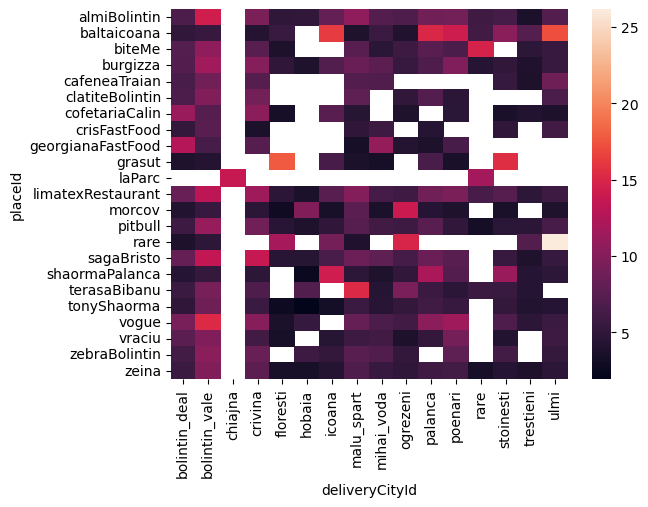

In [440]:
stat = data.placeId.value_counts().to_dict()
placeTrans = FunctionTransformer(threshold_func,kw_args={"name":"placeId","stat":stat,"threshold":20})

stat = data.deliveryCityId.value_counts().to_dict()
deliveryCityTrans = FunctionTransformer(threshold_func,kw_args={"name":"deliveryCityId","stat":stat,"threshold":20})

pipe.add_step("placeTrans",placeTrans)
pipe.add_step("deliveryCityTrans",deliveryCityTrans)
data = pipe.transform(data)

data["durationPerkm"] = data.total_duration_min/data.deliveryDistanceKm

pivot_table = data.pivot_table(index='placeId', columns='deliveryCityId', values='durationPerkm', aggfunc='mean')
sns.heatmap(pivot_table)
pipe 

### placeCompanyId have big variation on prepare time 
but small difference on wait gap

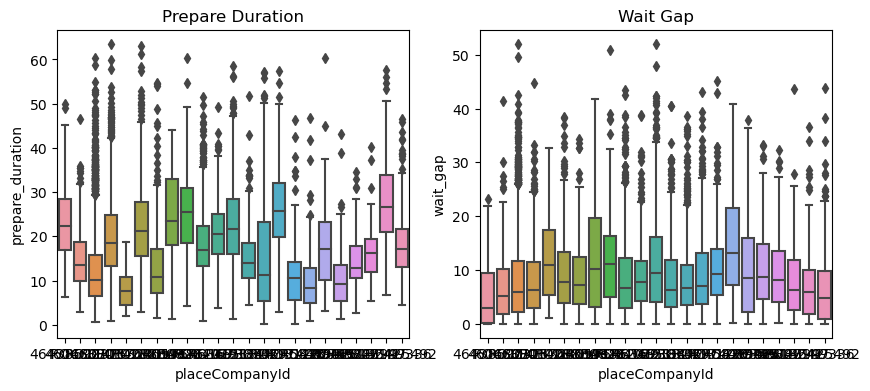

In [325]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(x="placeCompanyId", y="prepare_duration", data=data, ax=axes[0])
axes[0].set_title('Prepare Duration')

sns.boxplot(x="placeCompanyId", y="wait_gap", data=data, ax=axes[1])
axes[1].set_title('Wait Gap')

plt.show()

### placeId and laceCompanyId are one on one
so combine them is not nesessory

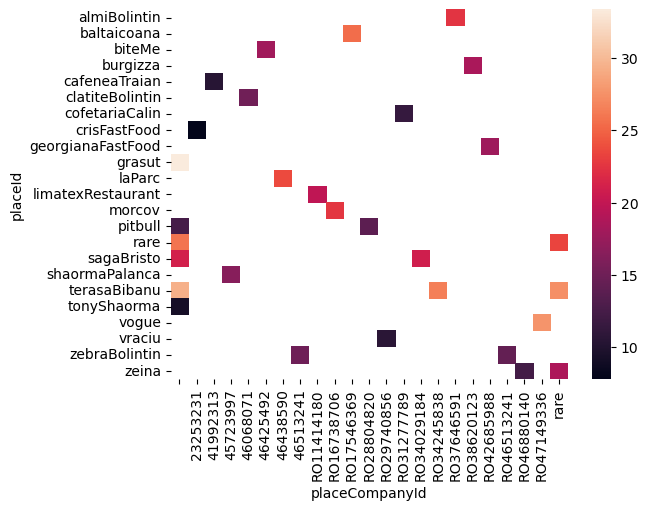

In [210]:
heattable = pd.pivot_table(data = data,index="placeId",columns="placeCompanyId",values="prepare_duration")
sns.heatmap(heattable)

#### driverUid on prepare_duration, wait_gap, durationPerkm
4 driver is aparently slower than other on durationPerkm and wait_gap but their deliver counts are small

so basicly drivers have no big difference on 3 duration.

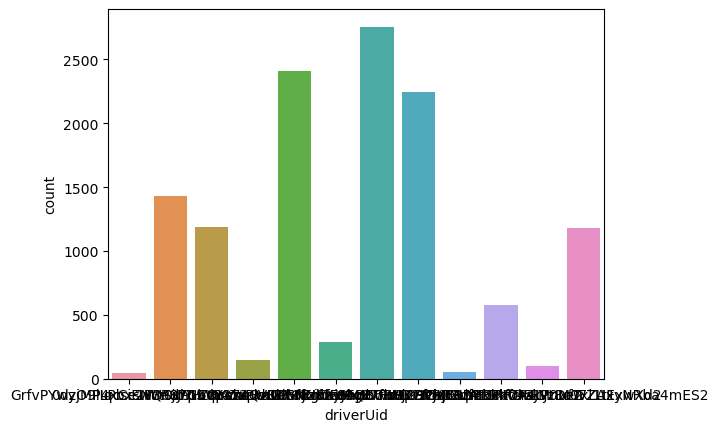

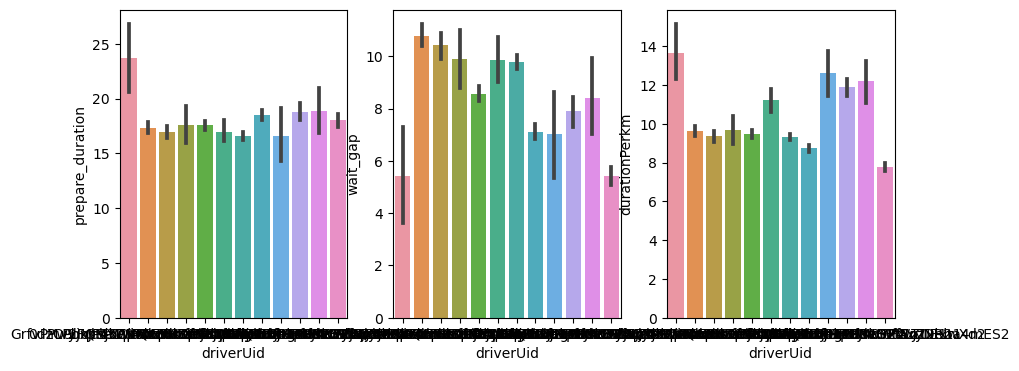

In [211]:
sns.countplot(x="driverUid",data=data)
plt.show()

fig, axes = plt.subplots(1,3, figsize=(10, 4))
sns.barplot(x="driverUid", y="prepare_duration", data=data, ax=axes[0])
sns.barplot(x="driverUid", y="wait_gap", data=data, ax=axes[1])
sns.barplot(x="driverUid", y="durationPerkm", data=data, ax=axes[2])
plt.show()


In [441]:
# data["created_date"] = data.created.map(lambda x :datetime.datetime.fromtimestamp(x//1000)) 
def time_fun(X,name,output=["hour","day"]):
    def f(x):
        ret = []
        if(pd.isna(x)):
            t = datetime.datetime.today 
        else: 
            t = datetime.datetime.fromtimestamp(x//1000)
        for name in output:
            if(name=="hour"):
                ret.append(t.hour)
            elif(name=="weekday"):
                ret.append(t.weekday())
            elif(name=="month"):
                ret.append(t.month)
            elif(name=="year"):
                ret.append(t.year)
            elif(name=="monthday"):
                ret.append(t.day)
        if(len(output)==1):
            return ret[0]
        else:
            return pd.Series(ret)
    X[output] = X[name].apply(func=f)
    return X

time_transformer= FunctionTransformer(func=time_fun,kw_args={"name":"created","output":["month","weekday","hour"]})
pipe.add_step("time_transformer",time_transformer)
data =time_transformer.transform(data)
data.head(2)


,placeId,deliveryCityId,deliveryDetails,placeLaLn,deliveryLaLn,deliveryDistanceKm,routeEstTravelTime,afoodDelivery,created,acceptedDelivery,...,total_duration_min,deliver_speed,placeLa,placeLn,deliveryLa,deliveryLn,durationPerkm,month,weekday,hour
0,laParc,chiajna,primarie contabilitate,"44.456306, 25.977077","44.46063,25.977156",2.6,1.5,True,1701080293822,1701081094978,...,23.676467,0.256167,44.456306,25.977077,44.460630,25.977156,9.106333,11,0,18
1,clatiteBolintin,bolintin_deal,Strada Dispensarului 3,"44.446605, 25.756946","44.452501,25.824015",5.6,7.3,True,1701079651647,1701080314408,...,37.195383,1.383439,44.446605,25.756946,44.452501,25.824015,6.642033,11,0,18


### hour and month have big viaration

bar diagram is better， violin is weaken by anomaly point

<Figure size 1000x1500 with 0 Axes>

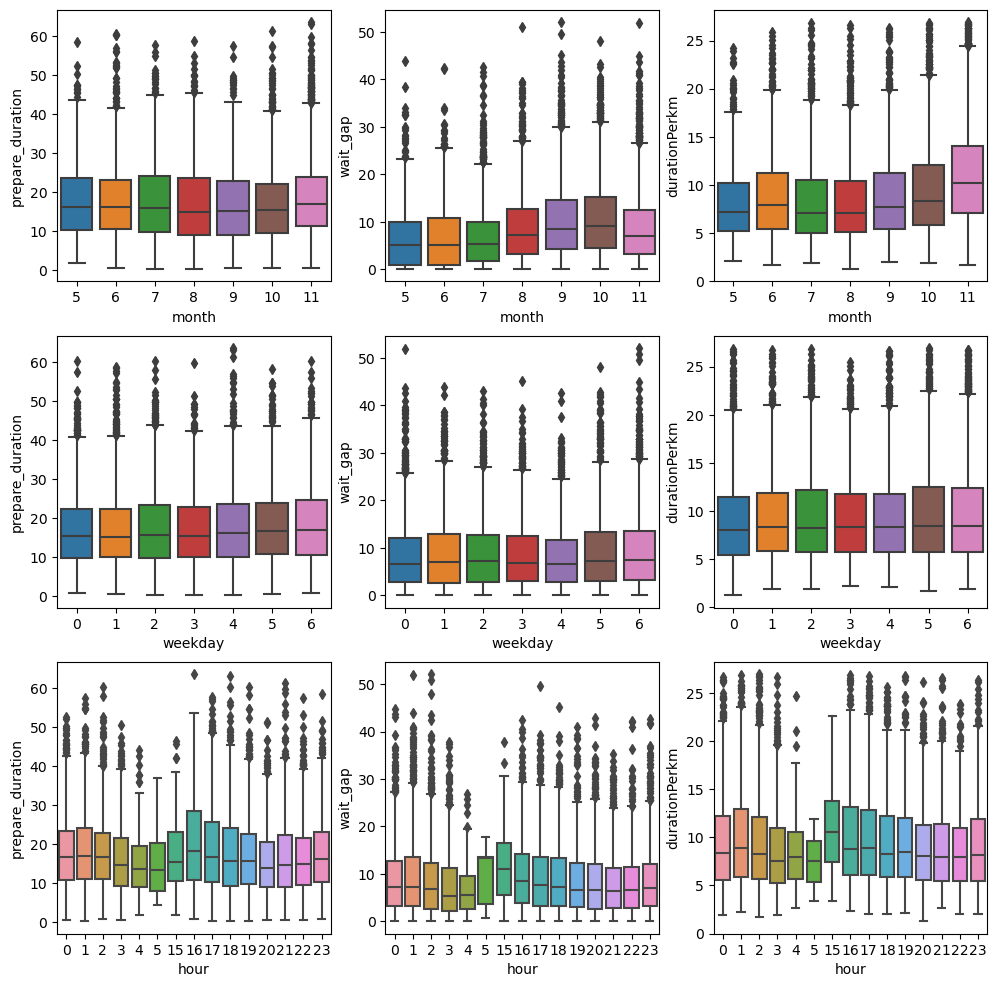

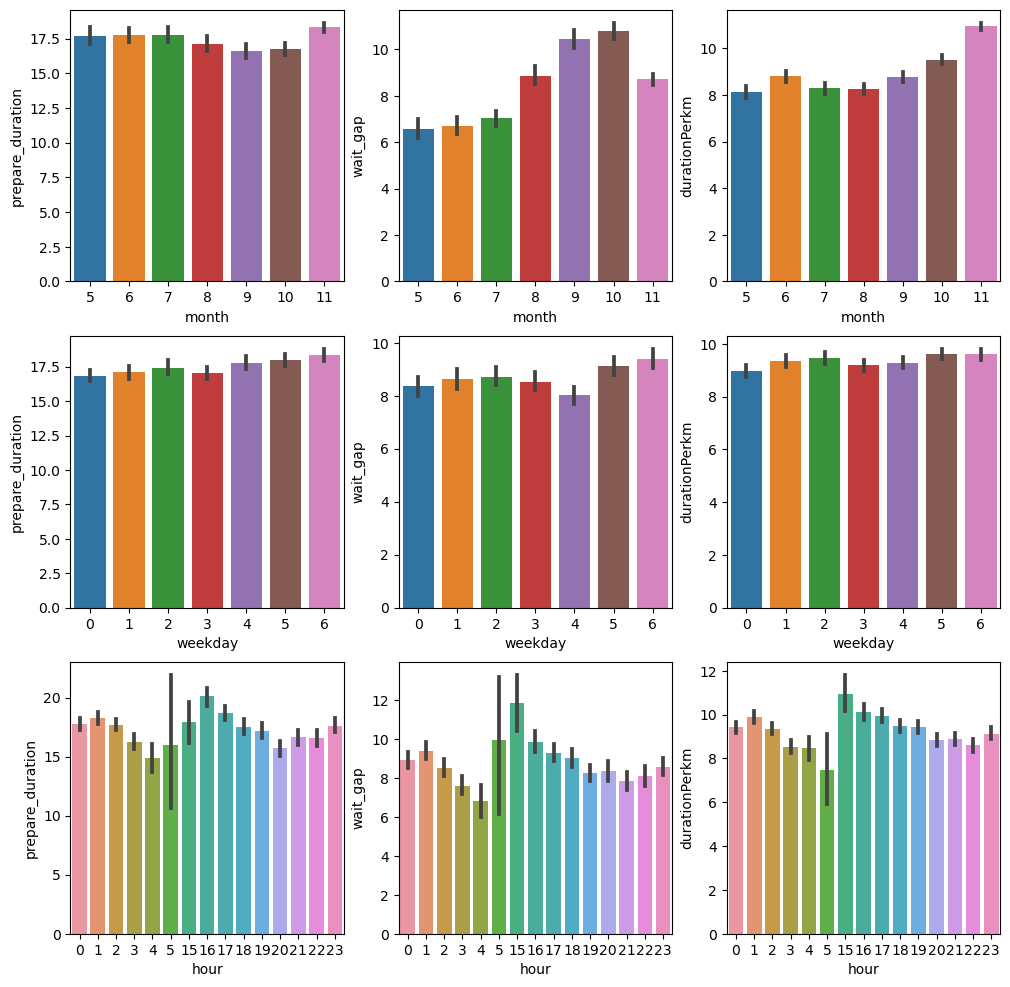

In [185]:
objs= ["prepare_duration","wait_gap","durationPerkm"]
cols = ["month","weekday","hour"]

plt.figure(figsize=(10,15))

fig, axes = plt.subplots(len(cols),len(objs), figsize=(12, 12))
i=0
j=0
for time_name in cols:
    for obj in objs:
        sns.boxplot(x=time_name,y=obj,data=data,ax=axes[i,j])
        j+=1
    i+=1
    j=0
plt.show()

fig, axes = plt.subplots(len(cols),len(objs), figsize=(12, 12))
i=0
j=0
for time_name in cols:
    for obj in objs:
        sns.barplot(x=time_name,y=obj,data=data,ax=axes[i,j])
        j+=1
    i+=1
    j=0
plt.show()
    

#### combination of hour and month is helpful according to heatmap

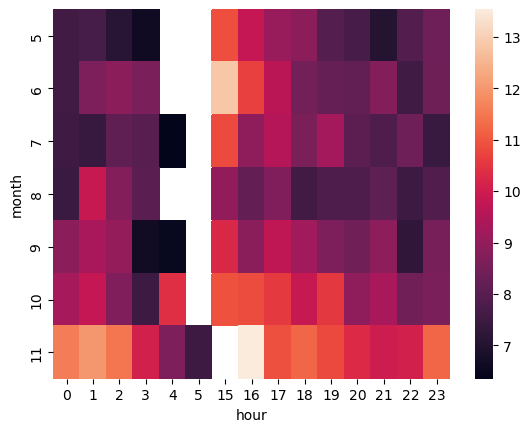

In [32]:
pivot_table = data.pivot_table(index='month', columns='hour', values='durationPerkm', aggfunc='mean')
sns.heatmap(pivot_table)



### feature preparation
- extract street from deliveryDetails
- extract product category from products
- product_len

In [442]:
def fun(X,name,output):
    def extract_street(string):
        if(pd.isna(string)):
            return "unk"
        lst =  re.findall(r"(\w+)",string)
        if(lst):
            return lst[0].strip().lower()
        else:
            return string.strip().lower()
    X[output]=X[name].apply(extract_street)
    return X

simple_street = FunctionTransformer(func=fun,kw_args={"name":"deliveryDetails","output":"street"})
data = simple_street.transform(data)

street_map = data.street.value_counts().to_dict()
street_shorten = FunctionTransformer(func=threshold_func,kw_args={"name":"street","stat":street_map,"threshold":20})
data = street_shorten.transform(data)

pipe.add_step("simple",simple_street)
pipe.add_step("shorten",street_shorten)

categories = {
        "MainDishes": set(['preparat', 'preparateporc', 'mancaregatita', 'platoucald', 'lacuptor', 'platou', 'gratar', 'peste', 'grill', 'preparate', 'preparatevita', 'preparatepui', 'fructedemare', 'burgeri', 'fastfood', 'main']),
        "Pizza":set( ['pizza', 'pizza28cm', 'pizza33cm']),
        "Wraps": set(['shaorme', 'burger', 'kebab', 'kebap', 'focaccia', 'sandwich']),
        "Beverages": set(['icedteas', 'bobatea', 'espresso', 'sucuri', 'softdrinks', 'coffeemilk', 'suc', 'bauturi', 'frappe', 'limonada', 'specialteas', 'racoritoare', 'apa']),
        "SidesStartersSnacks": set(['garnitura', 'garnituri', 'sos', 'cartofi', 'starters', 'sandwichuri', 'miniprajituri', 'smoothie', 'donnerbox', 'ciorbe', 'antreuri', 'brutarie', 'wraps', 'side', 'sosextra', 'falafel', 'salategarnituri', 'chifla']),
        "SoupsSalads": set(['ciorba', 'salateantreu', 'salate', 'supe', 'salata', 'oalacuciorbe']),
        "Desserts": set(['dulce', 'micdejun', 'prajituri', 'biteme', 'desert', 'fursecuri', 'clatite']),
        "SpecialCategoriesOffers": set(['pelanga', 'premium', 'promotie', 'gatite', 'pofte', 'diverse', 'meniu', 'jarincins', 'toate', 'meniuri', 'meniulzilei']),
        "Miscellaneous": set(['', 'cuuptor', 'asiatic'])
    }
reverse_categories={}
for k,v in categories.items():
    for i in v:
        reverse_categories[i] = k

def extract_product(X,name,output,stat):
    def fn(item_list):
        cat_list = []
        for item in item_list:
            cate_raw = item['category'].split(" ")[0].strip().lower()
            cate = stat.get(cate_raw,"Miscellaneous")
            cat_list.append(cate)
        if(cat_list):
            return ",".join(cat_list)
        else:
            return "Miscellaneous"
    X[output]=X[name].apply(fn)
    return X
product_extract = FunctionTransformer(func=extract_product,kw_args={"name":"products","output":"product_cat","stat":reverse_categories})
data = product_extract.transform(data)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
vectorizer.fit(data.product_cat)
print(vectorizer.get_feature_names_out())
print(vectorizer.vocabulary_)
def fun(X,name,vector):
    X[vector.get_feature_names_out()]=vector.transform(X[name]).toarray()
    return X

vector_transformer = FunctionTransformer(func=fun,kw_args={"name":"product_cat","vector":vectorizer})
pipe.add_step("product_extract",product_extract)
pipe.add_step("product_vector_transformer",vector_transformer)

data=vector_transformer.transform(data)
data



def products_len_fun(X,name,output):
    def fn(item_list):
        count = 0
        for item in item_list:
            count+=1
        if(count==0):
            return 1
        return count**0.2
    X[output] = X[name].apply(fn)
    return X
transformer= FunctionTransformer(func=products_len_fun,kw_args={"name":"products","output":"product_len_sqrt"})
pipe.add_step("product_len",transformer)
data = pipe.transform(data)
data




['beverages' 'desserts' 'maindishes' 'miscellaneous' 'pizza'
 'sidesstarterssnacks' 'soupssalads' 'specialcategoriesoffers' 'wraps']
{'maindishes': 2, 'specialcategoriesoffers': 7, 'desserts': 1, 'miscellaneous': 3, 'wraps': 8, 'pizza': 4, 'sidesstarterssnacks': 5, 'soupssalads': 6, 'beverages': 0}


,placeId,deliveryCityId,deliveryDetails,placeLaLn,deliveryLaLn,deliveryDistanceKm,routeEstTravelTime,afoodDelivery,created,acceptedDelivery,...,beverages,desserts,maindishes,miscellaneous,pizza,sidesstarterssnacks,soupssalads,specialcategoriesoffers,wraps,product_len_sqrt
0,laParc,chiajna,primarie contabilitate,"44.456306, 25.977077","44.46063,25.977156",2.6,1.5,True,1701080293822,1701081094978,...,0,0,1,0,0,0,0,0,0,1.000000
1,clatiteBolintin,bolintin_deal,Strada Dispensarului 3,"44.446605, 25.756946","44.452501,25.824015",5.6,7.3,True,1701079651647,1701080314408,...,0,2,0,0,0,0,0,1,0,1.245731
2,zeina,bolintin_deal,Strada Dispensarului 3,"44.44698515508772, 25.75288086524","44.452501,25.824015",6.5,8.3,True,1701079497666,1701080301077,...,0,0,0,3,0,0,0,0,0,1.245731
3,limatexRestaurant,bolintin_vale,Poarta luncii 91,"44.447887, 25.755343","44.437288,25.763221",2.6,3.1,True,1701079197247,1701080215614,...,0,0,0,0,1,0,0,0,1,1.148698
4,limatexRestaurant,malu_spart,principala nr 581 spre top speed,"44.447887, 25.755343","44.442733,25.715012",4.5,5.3,True,1701078973549,1701079968605,...,0,0,0,0,2,0,0,0,0,1.148698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12408,biteMe,ulmi,Principala 50bis,"44.448800, 25.755594","44.487278,25.781803",8.2,missing_value,True,1683532335182,1683533599472,...,0,1,0,0,0,1,1,0,1,1.319508
12409,biteMe,bolintin_vale,poarta luncii nr 117,"44.448800, 25.755594","44.437288,25.763221",2.6,missing_value,True,1683530690911,1683532207459,...,0,0,0,0,0,1,0,1,0,1.148698
12410,zeina,bolintin_vale,Libertății 179A,"44.44698515508772, 25.752880865222014","44.437288,25.763221",2.6,missing_value,True,1683487727172,1683487861110,...,0,0,0,1,0,0,0,0,0,1.000000
12411,zeina,bolintin_vale,"DJ151E & Strada Republicii, DJ601, DJ401A Ben...","44.44698515508772, 25.752880865222014","44.437288,25.763221",2.6,missing_value,True,1683487725846,1683488112721,...,0,0,0,2,0,0,0,0,0,1.148698


product_len by power 0.2 has nearly linear relationship with prepare_time

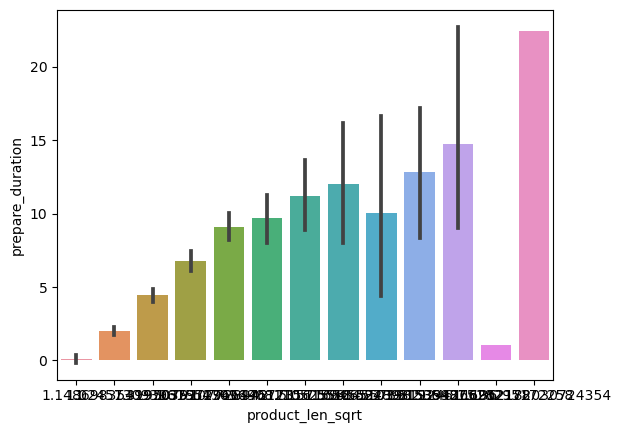

In [228]:
sns.barplot(x=data["product_len_sqrt"],y=data["prepare_duration"]-15)

In [443]:
# sin, cos time range to replace one hot encoding
# valid cycles "year,month,week,day"
def extractor(X,cycle,name,output):
    assert cycle in ["year","month","week","day"], f"{cycle} must in year,month,week,day"
    def sincos_time(timestamp):
        curtime = datetime.datetime.fromtimestamp(timestamp//1000)
        result = []
        rate = 0
        if(pd.isna(curtime)):
            rate = 0
        elif(cycle=="week"):   
            rate = (curtime.weekday()*24*3600+curtime.hour*24+curtime.minute*60+curtime.second)/(7*24*3600)
        elif(cycle=="day"):
            rate = (curtime.hour*3600+curtime.minute*60+curtime.second)/(24*3600)
        elif(cycle=="year"):
            # 获取当年年初的日期
            start_of_year = datetime.datetime(curtime.year, 1, 1)
            seconds_since_start_of_year = (curtime - start_of_year).total_seconds()
            rate = seconds_since_start_of_year/(265*24*3600)
        elif(cycle=="month"):
            start_of_month = datetime.datetime(curtime.year, curtime.month, 1)
            seconds_from_start_of_monther = (curtime - start_of_month).total_seconds()
            rate = seconds_from_start_of_monther/(30.5*24*3600)
        result.append(np.sin(2*np.pi*rate))
        result.append(np.cos(2*np.pi*rate))
        return pd.Series(result)
    X[output] = X[name].apply(sincos_time)
    return X

month_sincos = FunctionTransformer(func=extractor,kw_args={"cycle":"month","name":"created","output":["month_sin","month_cos"]})
pipe.add_step("month_sincos",month_sincos)


day_sincos = FunctionTransformer(func=extractor,kw_args={"cycle":"day","name":"created","output":["day_sin","day_cos"]})

week_sincos = FunctionTransformer(func=extractor,kw_args={"cycle":"week","name":"created","output":["week_sin","week_cos"]})
pipe.add_step("day_sincos",day_sincos)
pipe.add_step("week_sincos",week_sincos)
data = pipe.transform(data)
data.head()


,placeId,deliveryCityId,deliveryDetails,placeLaLn,deliveryLaLn,deliveryDistanceKm,routeEstTravelTime,afoodDelivery,created,acceptedDelivery,...,soupssalads,specialcategoriesoffers,wraps,product_len_sqrt,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos
0,laParc,chiajna,primarie contabilitate,"44.456306, 25.977077","44.46063,25.977156",2.6,1.5,True,1701080293822,1701081094978,...,0,0,0,1.000000,-0.696075,0.717969,-0.996843,0.079402,0.015842,0.999875
1,clatiteBolintin,bolintin_deal,Strada Dispensarului 3,"44.446605, 25.756946","44.452501,25.824015",5.6,7.3,True,1701079651647,1701080314408,...,0,1,0,1.245731,-0.697174,0.716902,-0.999462,0.032792,0.009173,0.999958
2,zeina,bolintin_deal,Strada Dispensarului 3,"44.44698515508772, 25.75288086524","44.452501,25.824015",6.5,8.3,True,1701079497666,1701080301077,...,0,0,0,1.245731,-0.697437,0.716646,-0.999767,0.021597,0.007573,0.999971
3,limatexRestaurant,bolintin_vale,Poarta luncii 91,"44.447887, 25.755343","44.437288,25.763221",2.6,3.1,True,1701079197247,1701080215614,...,0,0,1,1.148698,-0.697949,0.716147,-1.000000,-0.000218,0.041595,0.999135
4,limatexRestaurant,malu_spart,principala nr 581 spre top speed,"44.447887, 25.755343","44.442733,25.715012",4.5,5.3,True,1701078973549,1701079968605,...,0,0,0,1.148698,-0.698332,0.715774,-0.999864,-0.016507,0.039270,0.999229


### delivery focus on week end and 3 pm
more delivery and more slow

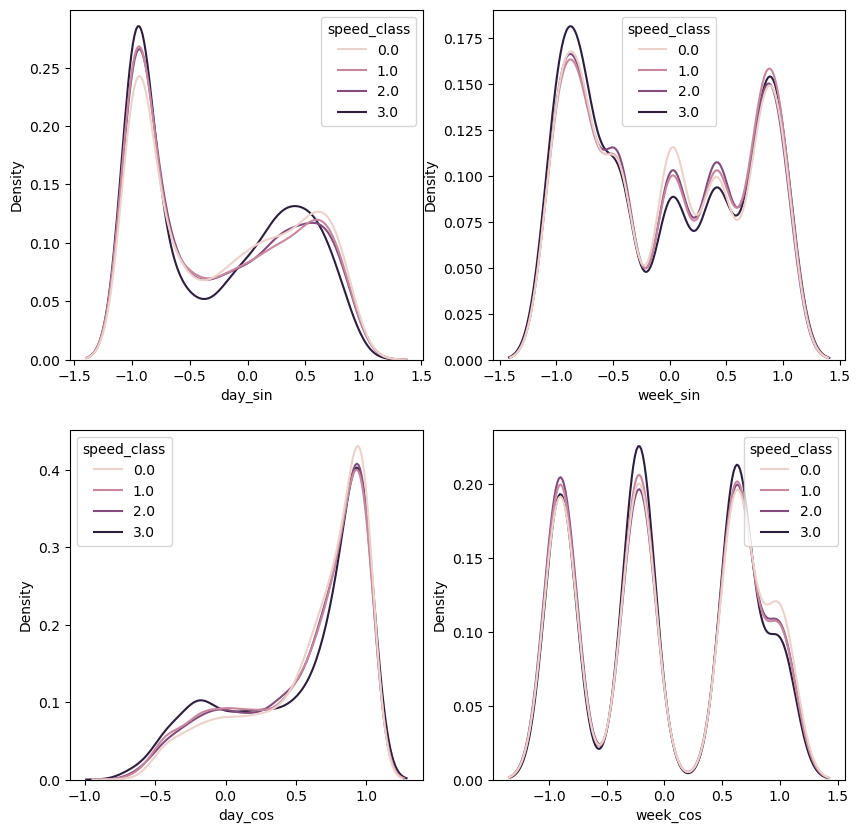

In [230]:
kb = KBinsDiscretizer(n_bins=4,encode="ordinal",strategy="quantile")
ds = np.reshape(data["durationPerkm"].values,[-1,1])
data["speed_class"] = kb.fit_transform(ds)
fig,axes = plt.subplots(2,2,figsize=(10,10))
sns.kdeplot(data=data,x="day_sin",hue="speed_class",ax=axes[0,0])
sns.kdeplot(data=data,x="week_sin",hue="speed_class",ax=axes[0,1])
sns.kdeplot(data=data,x="day_cos",hue="speed_class",ax=axes[1,0])
sns.kdeplot(data=data,x="week_cos",hue="speed_class",ax=axes[1,1])



####  driverPaysOnPickup is kept

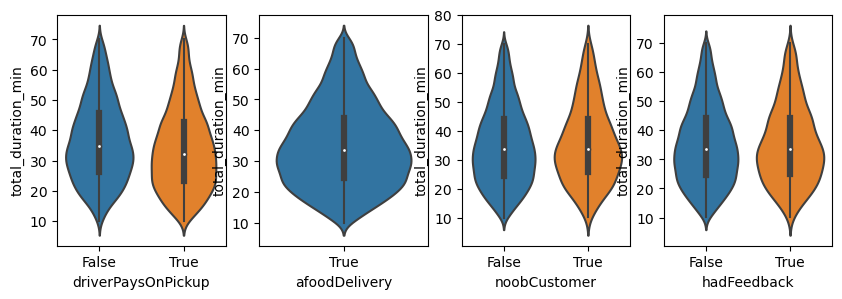

In [231]:
# df["driverPaysOnPickup"] = df["driverPaysOnPickup"].map(lambda x: 1 if( x) else 0)
# df["afoodDelivery"]=df["afoodDelivery"].map(lambda x: 1 if(x) else 0)

# df["noobCustomer"] = df.noobCustomer.map(lambda x: 1 if( x) else 0)
# df["hadFeedback"]=df.hadFeedback.map(lambda x: 1 if(x) else 0)
from sklearn.preprocessing import OrdinalEncoder


fig,axes = plt.subplots(1,4,figsize=(10,3))
for i,name in enumerate(["driverPaysOnPickup","afoodDelivery","noobCustomer","hadFeedback"]):
    sns.violinplot(x=data[name],y=data.total_duration_min,ax=axes[i])
    


## do some feature engineering according to above analysis
-- experiment proved that statistics on target by category is very helpful


In [444]:


# df["speed_delivery"] = df.deliver_duration/(df.deliveryDistanceKm)
# df["speed_prepare"] = df.prepare_duration
def fun(X,name,output):
    X[output] = X[name].apply(lambda row: "_".join([str(i) for i in row.values]),axis=1)
    return X
combine_transformer = FunctionTransformer(func=fun,kw_args={"name":["placeId","deliveryCityId"],"output":"placeid_delivercity"})
pipe.add_step("placeid_delivercity",combine_transformer)
pipe.add_step("placeid_delivercity_street",FunctionTransformer(func=fun,kw_args={"name":["placeId","deliveryCityId","street"],"output":"placeid_delivercity_street"}))
pipe.add_step("weekday_hour",FunctionTransformer(func=fun,kw_args={"name":["weekday","hour"],"output":"weekday_hour"}))
data = pipe.transform(data)


In [445]:


def groubyop_distance(X,name,stat_map,output):
    distance = X["deliveryDistanceKm"]
    try:
        def myfun(x):
            ret = stat_map.get(x,0)
            if(pd.isna(ret)):
                ret = 0
            return ret
        
        X[output]=X[name].apply(myfun).astype("float")
        X[output] = X[output]*distance
    except Exception as e:
        print(name,output,stat_map)
        print(X[output].dtype)
        raise e
    return X
# df["speed_placeId_CityId"] = df.groupby(by=["placeId","deliveryCityId"])["speed_delivery"].transform("mean")
# df["speed_placeId_CityId_std"] = df.groupby(by=["placeId","deliveryCityId"])["speed_delivery"].transform("std")
# df["speed_placeId_CityId_street"] = df.groupby(by=["placeId","deliveryCityId","street"])["speed_delivery"].transform("mean")
# df["speed_placeId_CityId_street_std"] = df.groupby(by=["placeId","deliveryCityId"])["speed_delivery"].transform("std")
stat_map = data.groupby("placeid_delivercity")["durationPerkm"].mean().to_dict()
pipe.add_step("placeId_CityId_esttime",FunctionTransformer(groubyop_distance
                                                           ,kw_args={"name":"placeid_delivercity","stat_map":stat_map
                                                                     ,"output":"placeId_CityId_esttime"}))
# stat_map = data.groupby("placeid_delivercity")["durationPerkm"].std().to_dict()
# pipe.add_step("std_placeId_CityId",FunctionTransformer(groubyop,kw_args={"name":"placeid_delivercity","stat_map":stat_map,"output":"std_placeId_CityId"}))
stat_map = data.groupby("placeid_delivercity_street")["durationPerkm"].mean().to_dict()
pipe.add_step("placeId_street_CityId_esttime",FunctionTransformer(groubyop_distance,kw_args={"name":"placeid_delivercity_street"
                                                                           ,"stat_map":stat_map,"output":"placeId_street_CityId_esttime"}))
# stat_map = data.groupby("placeid_delivercity_street")["durationPerkm"].std().to_dict()
# pipe.add_step("std_placeId_street_CityId",FunctionTransformer(groubyop,kw_args={"name":"placeid_delivercity_street"
#                                                                            ,"stat_map":stat_map,"output":"std_placeId_street_CityId"}))

# df["speed_driverUid"] = df.groupby(by="driverUid")["speed_delivery"].transform("mean")
# df["speed_driverUid_std"] = df.groupby(by="driverUid")["speed_delivery"].transform("std")

stat_map = data.groupby("driverUid")["durationPerkm"].mean().to_dict()
tranformer = FunctionTransformer(groubyop_distance,kw_args={"name":"driverUid"
                                                                           ,"stat_map":stat_map,"output":"driverUid_esttime"})
# data = tranformer.transform(data)
pipe.add_step("driverUid_esttime",tranformer)
# stat_map = data.groupby("driverUid")["durationPerkm"].std().to_dict()
# pipe.add_step("std_driverUid",FunctionTransformer(groubyop,kw_args={"name":"driverUid"
#                                                                            ,"stat_map":stat_map,"output":"std_driverUid"}))

stat_map = data.groupby("weekday_hour")["durationPerkm"].mean().to_dict()
pipe.add_step("weekday_hour_esttime",FunctionTransformer(groubyop_distance,kw_args={"name":"weekday_hour"
                                                                           ,"stat_map":stat_map,"output":"weekday_hour_esttime"}))
# df["wait_placeId"] = df.groupby(by="placeId")["wait_gap"].transform("mean")
# df["wait_placeId_std"] = df.groupby(by="placeId")["wait_gap"].transform("std")
def groubyop(X,name,stat_map,output):
    def myfun(x):
        ret = stat_map.get(x,0)
        if(pd.isna(ret)):
            ret = 0
        return ret
    X[output]=X[name].apply(myfun)
    return X

stat_map = data.groupby("placeId")["wait_gap"].mean().to_dict()
pipe.add_step("wait_placeId",FunctionTransformer(groubyop,kw_args={"name":"placeId"
                                                                           ,"stat_map":stat_map,"output":"wait_placeId"}))
stat_map = data.groupby("placeId")["wait_gap"].std().to_dict()
pipe.add_step("wait_placeId_std",FunctionTransformer(groubyop,kw_args={"name":"placeId"
                                                                           ,"stat_map":stat_map,"output":"wait_placeId_std"}))

# df["wait_driverUid"] = df.groupby(by="driverUid")["wait_gap"].transform("mean")
# df["wait_driverUid_std"] = df.groupby(by="driverUid")["wait_gap"].transform("std")


stat_map = data.groupby("driverUid")["wait_gap"].mean().to_dict()
pipe.add_step("wait_driverUid",FunctionTransformer(groubyop,kw_args={"name":"driverUid"
                                                                           ,"stat_map":stat_map,"output":"wait_driverUid"}))
# stat_map = data.groupby("driverUid")["wait_gap"].std().to_dict()
# pipe.add_step("wait_driverUid_std",FunctionTransformer(groubyop,kw_args={"name":"driverUid"
#                                                                            ,"stat_map":stat_map,"output":"wait_driverUid_std"}))

data["prepare_speed"] = data.prepare_duration/data.product_len_sqrt
def groubyop_prepare(X,name,stat_map,output):
    product_len = X["product_len_sqrt"]
    def myfun(x):
        ret = stat_map.get(x,0)
        if(pd.isna(ret)):
            ret = 0
        return ret
    X[output]=X[name].apply(myfun)*product_len
    return X

stat_map = data.groupby("placeId")["prepare_speed"].mean()
pipe.add_step("prepare_placeId"
,FunctionTransformer(groubyop_prepare,kw_args={"name":"placeId","stat_map":stat_map,"output":"prepare_placeId"}))

# stat_map = data.groupby("placeId")["prepare_speed"].std()
# pipe.add_step("speed_prepare_placeId_std"
# ,FunctionTransformer(groubyop,kw_args={"name":"placeId","stat_map":stat_map,"output":"speed_prepare_placeId_std"}))

stat_map = data.groupby("month")["prepare_speed"].mean()
pipe.add_step("prepare_month"
,FunctionTransformer(groubyop_prepare,kw_args={"name":"month","stat_map":stat_map,"output":"prepare_month"}))

stat_map = data.groupby("hour")["prepare_speed"].mean()
pipe.add_step("prepare_hour"
,FunctionTransformer(groubyop_prepare,kw_args={"name":"hour","stat_map":stat_map,"output":"prepare_hour"}))

# df["speed_prepare"] = df.speed_prepare/df["product_len"]
# df["speed_prepare_placeId"] = df.groupby(by=["placeId","placeCompanyId"])["speed_prepare"].transform("mean")
# df["prepare_placeId_std"] = df.groupby(by="placeId")["speed_prepare"].transform("std")

data = pipe.transform(data)


# df["est_time1"] = df.speed_placeId_CityId*df.deliveryDistanceKm
# df["est_time2"] = df.speed_placeId_CityId_street*df.deliveryDistanceKm
# df["est_time3"] = df.speed_driverUid*df.deliveryDistanceKm



# df["est_prepare_time"] = df["speed_prepare_placeId"]*df["product_len"]

In [446]:
y = data.total_duration_min
y_scaler = StandardScaler()
y = y_scaler.fit_transform(np.reshape(y.values,[-1,1]))
keep_columns = ['placeId', 'deliveryCityId',
        'deliveryDistanceKm',
        'driverUid', 'placeCompanyId', 'driverPaysOnPickup',
       'placeLa', 'placeLn', 'deliveryLa', 'deliveryLn',
       'month', 'weekday', 'hour', 'street', 'beverages',
       'desserts', 'maindishes', 'miscellaneous', 'pizza',
       'sidesstarterssnacks', 'soupssalads', 'specialcategoriesoffers',
       'wraps', 'product_len_sqrt', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'week_sin', 'week_cos', 'placeid_delivercity',
       'placeid_delivercity_street', 'weekday_hour', 'placeId_CityId_esttime',
       'placeId_street_CityId_esttime', 'driverUid_esttime',
       'weekday_hour_esttime', 'wait_placeId', 'wait_placeId_std',
       'wait_driverUid', 'prepare_placeId', 'prepare_month', 'prepare_hour']
def keep(X,names):
    return X[names]

keep_transformer = FunctionTransformer(func = keep,kw_args={"names":keep_columns})
xgboost_pipe = Pipeline(steps = pipe.steps.copy())
xgboost_pipe.add_step("keep",keep_transformer)

cat_clos = ['placeId', 'deliveryCityId',"driverUid","placeCompanyId","month","weekday","hour","street","placeid_delivercity"
            ,"placeid_delivercity_street","weekday_hour"]
num_cols =["deliveryDistanceKm","placeLa","placeLn","deliveryLa","deliveryLn", 'placeId_CityId_esttime',
       'placeId_street_CityId_esttime', 'driverUid_esttime',
       'weekday_hour_esttime', 'wait_placeId', 'wait_placeId_std',
       'wait_driverUid', 'prepare_placeId', 'prepare_month', 'prepare_hour']
num_scaler = StandardScaler()
num_scaler.fit(data[num_cols])
def cat_num_transfer(X,cats,nums,scaler):
    for n in cats:
        print(n)
        X[n] = X[n].astype("category")
    X[nums] = scaler.transform(X[nums])
    return X
cat_num_transformer = FunctionTransformer(func = cat_num_transfer,kw_args={"cats":cat_clos,"nums":num_cols,"scaler":num_scaler} )
# xgboost_pipe = Pipeline(steps = pipe.steps.copy())
xgboost_pipe.add_step("cat_num",cat_num_transformer)
d = xgboost_pipe.transform(data)
d


placeId
deliveryCityId
driverUid
placeCompanyId
month
weekday
hour
street
placeid_delivercity
placeid_delivercity_street
weekday_hour


,placeId,deliveryCityId,deliveryDistanceKm,driverUid,placeCompanyId,driverPaysOnPickup,placeLa,placeLn,deliveryLa,deliveryLn,...,placeId_CityId_esttime,placeId_street_CityId_esttime,driverUid_esttime,weekday_hour_esttime,wait_placeId,wait_placeId_std,wait_driverUid,prepare_placeId,prepare_month,prepare_hour
0,laParc,chiajna,-0.709738,GrfvPYwyjMP4xCiFwtm07pSVY3z2,46438590,True,0.928284,11.631985,1.011938,6.778915,...,0.096348,0.291630,-0.258664,-0.652425,-2.364978,-0.768212,-2.029364,0.310664,-0.640467,-0.989089
1,clatiteBolintin,bolintin_deal,0.401044,0dzO9lIqcse1Wt0u9HDC4TaPkaG3,46068071,False,0.163055,-0.010073,0.547627,1.951314,...,0.364053,0.166906,0.486274,0.504044,-1.328463,-0.812796,1.281821,-0.132049,1.276488,0.679874
2,zeina,bolintin_deal,0.734278,0dzO9lIqcse1Wt0u9HDC4TaPkaG3,RO46880140,True,0.193043,-0.225066,0.547627,1.951314,...,0.189881,-0.094591,0.837010,0.850984,-0.580258,-0.019599,1.281821,-0.698974,1.276488,0.679874
3,limatexRestaurant,bolintin_vale,-0.709738,PLPbxsM3P8YGVGKznLRr0DbMzif2,RO11414180,False,0.264181,-0.094851,-0.321306,0.034850,...,-0.084464,0.039898,-0.711132,-0.594819,-0.708937,-1.485749,1.056828,0.516501,0.519534,0.462988
4,limatexRestaurant,malu_spart,-0.006243,PLPbxsM3P8YGVGKznLRr0DbMzif2,RO11414180,False,0.264181,-0.094851,-0.010300,-1.484885,...,1.233293,1.290416,0.008641,0.179708,-0.708937,-1.485749,1.056828,0.516501,0.519534,0.462988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12408,biteMe,ulmi,1.363721,xTdFRYruaje5pB6Yu199I501wYE2,46425492,False,0.336200,-0.081576,2.534015,0.620627,...,1.169993,1.075608,1.400399,1.388569,-1.594755,-0.838696,0.661020,0.584453,1.312575,1.435680
12409,biteMe,bolintin_vale,-0.709738,xTdFRYruaje5pB6Yu199I501wYE2,46425492,False,0.336200,-0.081576,-0.321306,0.034850,...,-0.890039,-0.873427,-0.714272,-0.689759,-1.594755,-0.838696,0.661020,0.104471,0.049915,0.242597
12410,zeina,bolintin_vale,-0.709738,Jh16qpohqwhvPiOjUbfFShHbuPH3,RO46880140,True,0.193043,-0.225066,-0.321306,0.034850,...,-1.171945,-1.194359,-0.699025,-0.952033,-0.580258,-0.019599,-0.090266,-1.177216,-1.049294,-1.395735
12411,zeina,bolintin_vale,-0.709738,Jh16qpohqwhvPiOjUbfFShHbuPH3,RO46880140,True,0.193043,-0.225066,-0.321306,0.034850,...,-1.171945,-1.148860,-0.699025,-0.952033,-0.580258,-0.019599,-0.090266,-0.887819,0.049915,-0.446268


#### train on 5 folds to evaluate model without bias

In [509]:

def ensemble_train(data,y,pred_col="predict",model_name="xgb",cat_cols=[]):
    assert model_name in (["xgb","lgb","tabnet","mlp","ft","resnet"])
    mydata = data.copy()
    feature_names= mydata.columns.tolist()
    mydata[pred_col]=0
    if(model_name=="tabnet"):
        cat_idxs = []
        cat_dims = []
        if(cat_cols):
            for name in cat_cols:
                cat_idxs.append(feature_names.index(name))
                cat_dims.append(mydata[name].nunique())   
        groups = [['beverages', 'desserts', 'maindishes', 'miscellaneous', 'pizza', 'sidesstarterssnacks', 'soupssalads', 'specialcategoriesoffers']
                  ,['month_sin','month_cos'],['week_sin','week_cos'],['day_sin','day_cos']
                 ]
        features = mydata.columns.to_list()
        for gr in groups:
            for i in range(len(gr)):
                name = gr[i]
                gr[i] = features.index(name)
        print("groups",groups)

    elif(model_name=="ft"):
        cat_idxs = []
        cat_dims = []
        if(cat_cols):
            for name in cat_cols:
                cat_idxs.append(feature_names.index(name))
                cat_dims.append(mydata[name].nunique())   
    elif(model_name=="resnet"):
        final = [mydata]
        for name in cat_cols:
            one_hot_encoded = pd.get_dummies(mydata.pop(name), prefix=name)
            final.append(one_hot_encoded)

        mydata = pd.concat(final,axis=1)

    kf  = KFold(n_splits=5,random_state=42,shuffle=True)
    for i,(train_index,test_index) in enumerate(kf.split(mydata)):
        train_data = mydata.loc[train_index].drop(pred_col,axis=1)
        train_label = y[train_index]
        test_data = mydata.loc[test_index].drop(pred_col,axis=1)
        test_label = y[test_index]
        
        if(model_name=="xgb"):
            model = XGBRegressor(n_estimators = 1000,enable_categorical =True
                          ,device="gpu:0",random_state=42,colsample_bytree =0.8
                         ,learning_rate = 0.1,max_depth=6,subsample=0.8,n_jobs=10,num_leaves=20)
            model.fit(train_data, train_label
                  ,eval_set=[(test_data,test_label)]
                  ,eval_metric="rmse"
                  ,early_stopping_rounds=200,verbose=100) 
        elif(model_name=="lgb"):
            model:LGBMRegressor = LGBMRegressor(n_estimators=1000,random_state=42,colsample_bytree =0.8
                         ,learning_rate = 0.1,subsample=0.8,n_jobs=10,num_leaves=20)
            model.fit(train_data, train_label,eval_set=[(test_data,test_label)]
                      ,eval_metric="rmse"
                    ,callbacks=[lightgbm.early_stopping(50, verbose=100)])
            model.feature_names_in_ = train_data.columns 
        elif(model_name=="tabnet"):
            y_train = train_label
            y_test = test_label
            x_train = train_data.values
            x_test = test_data.values 
            unsupervised_model = TabNetPretrainer(
                                n_d=32,                     # 决策预测的维度
                                n_a=32,                     # 注意力的维度
                                n_steps=3,                 # 决策步骤的数量
                                gamma=1.5,                 # 特征选择的强度
                                cat_idxs=cat_idxs,         # 类别特征的索引
                                cat_dims=cat_dims,         # 类别特征的维度
                                cat_emb_dim=3,             # 类别特征的嵌入维度
                                n_independent=2,           # 独立特征转换层的数量
                                n_shared=2,                # 共享特征转换层的数量
                                lambda_sparse=0.001,       # 稀疏正则化项的权重
                                optimizer_fn=torch.optim.Adam, # 优化器
                                optimizer_params=dict(lr=2e-2), # 优化器的参数
                                mask_type="entmax",# 'sparsemax',      # 特征选择的掩码类型
                                device_name = "cuda",
                                verbose = 30,
                                grouped_features = groups)
            unsupervised_model.fit(
                X_train=x_train,
                eval_set=[x_test],
                pretraining_ratio=0.2,
                max_epochs=50,
                patience=50,
                batch_size=256,
                virtual_batch_size=128,
                warm_start=True
            )            
            
            # 初始化TabNetRegressor
            model = TabNetRegressor(
                n_d=32,                     # 决策预测的维度
                n_a=32,                     # 注意力的维度
                n_steps=3,                 # 决策步骤的数量
                gamma=1.5,                 # 特征选择的强度
                cat_idxs=cat_idxs,         # 类别特征的索引
                cat_dims=cat_dims,         # 类别特征的维度
                cat_emb_dim=3,             # 类别特征的嵌入维度
                n_independent=2,           # 独立特征转换层的数量
                n_shared=2,                # 共享特征转换层的数量
                lambda_sparse=0.001,       # 稀疏正则化项的权重
                optimizer_fn=torch.optim.Adam, # 优化器
                optimizer_params=dict(lr=2e-2), # 优化器的参数
                mask_type="entmax",# 'sparsemax',      # 特征选择的掩码类型
                device_name = "cuda",
                verbose = 30,
                grouped_features = groups
            )
            model.fit(
                X_train=x_train, y_train=y_train,
                eval_set=[(x_test, y_test)],
                eval_name=['test'],
                eval_metric=['mse'],
                max_epochs=1000,
                patience=50,
                batch_size=2560,
                virtual_batch_size=128,
                drop_last=False,
                num_workers=0, # notebook条件下， num_workers>0 特别的慢
                from_unsupervised= unsupervised_model
            )
        elif(model_name=="ft"):
            _,fea_num = train_data.shape
            test_label = np.squeeze(test_label,-1)
            train_label = np.squeeze(train_label,-1)
            print(fea_num-len(cat_cols))
            model = FT_Transformer(n_num_features=fea_num-len(cat_cols),n_feature_size=32,n_blocks=3,cat_idxs=cat_idxs,cat_dims=cat_dims)
            model.fit(X=train_data,y=train_label,eval_set=(test_data,test_label),eval_metric="mse",batch_size=256,max_epochs=1000,vobosity =20)

        elif(model_name=="resnet"):
            dataset = tf.data.Dataset.from_tensor_slices((train_data.values,train_label)).shuffle(buffer_size = 10000).batch(batch_size=512).repeat()
            val_dataset= tf.data.Dataset.from_tensor_slices((test_data.values,test_label)).batch(batch_size=128)
            feature_size = train_data.shape[1]
            inp = tf.keras.Input(shape=(feature_size,))
            l1 =  tf.keras.layers.Dense(units=32, activation=None)(inp)
            l2 = tf.keras.layers.Dense(units = 64,activation = tf.keras.backend.relu)(l1)
            l3 = tf.keras.layers.Dense(units=32, activation=None)(l2)
            l4 = l1+l3
            l5 = tf.keras.backend.dropout(l4,level=0.1)
            outp =  tf.keras.layers.Dense(units=1)(l5)
            model = tf.keras.Model( inputs=inp,outputs=outp)
            model.compile(loss=tf.keras.losses.mean_squared_error
                          ,metrics=[tf.keras.metrics.mae
                                    ,tf.keras.metrics.mse],optimizer="adam")
#             model(iter(dataset).next()[0])
#             model.save_weights("weights/time_prediction/weight")
#             model.load_weights("weights/time_prediction/weight")
            history= model.fit(x=dataset,validation_data=val_dataset,epochs=100,steps_per_epoch=50,verbose=0
                               ,callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=20)])
        if(model_name in ["resnet","tabnet","ft"]):
            predict_value = model.predict(test_data.values)
        else:
            predict_value = model.predict(test_data)
        err = mean_squared_error(test_label,predict_value,squared=False)
        print(f"round{i}:\trmse = {err}")
        mydata.loc[test_index,pred_col] = predict_value
        
    mydata["label"] = y_scaler.inverse_transform(y) 
    mydata[pred_col] = y_scaler.inverse_transform(np.reshape(mydata[pred_col].values,[-1,1]))
    err = mean_squared_error(mydata["label"],mydata[pred_col],squared=False)
    print(f"final rmse for all = {err}")
    
    duration_label = mydata["label"]
    duration_pred = mydata[pred_col]

    score1 = mean_absolute_error(y_true=duration_label,y_pred=duration_pred)
    print(f"mean_absolute_error is {score1}")
    score2 = mean_squared_error(y_true=duration_label,y_pred=duration_pred,squared=False)
    print(f"mean_squared_error is {score2}")
    close = [1 for x1, x2 in zip(duration_label,duration_pred) if(abs(x1-x2)<10) ]
    print(f"precision for good is {len(close)/len(duration_pred)}")
    close = [1 for x1, x2 in zip(duration_label,duration_pred) if(abs(x1-x2)<15) ]
    print(f"precision for medium is {len(close)/len(duration_pred)}")
    
    _,axes = plt.subplots(1,2,figsize=(8,4))
    sns.kdeplot(x=[(x1-x2) for x1, x2 in zip(duration_label,duration_pred) ],ax=axes[0])
    sns.kdeplot(x="label",data=mydata,ax=axes[1],legend=True)
    sns.kdeplot(x=pred_col,data=mydata,ax=axes[1],legend=True)
    plt.show()

    if(model_name not in ["resnet","ft"]):

        plt.figure(figsize=(8,10))
        plt.barh(feature_names,width=model.feature_importances_)


[0]	validation_0-rmse:0.95933
[100]	validation_0-rmse:0.80498
[200]	validation_0-rmse:0.81859
[225]	validation_0-rmse:0.82184
round0:	rmse = 0.7917495426180127
[0]	validation_0-rmse:0.96036
[100]	validation_0-rmse:0.81220
[200]	validation_0-rmse:0.82380
[220]	validation_0-rmse:0.82684
round1:	rmse = 0.7984360950098502
[0]	validation_0-rmse:0.96977
[100]	validation_0-rmse:0.80264
[200]	validation_0-rmse:0.81764
[223]	validation_0-rmse:0.82054
round2:	rmse = 0.7827562691897619
[0]	validation_0-rmse:0.96242
[100]	validation_0-rmse:0.81662
[200]	validation_0-rmse:0.82554
[220]	validation_0-rmse:0.82769
round3:	rmse = 0.7981149035108822
[0]	validation_0-rmse:0.97257
[100]	validation_0-rmse:0.81003
[200]	validation_0-rmse:0.82543
[229]	validation_0-rmse:0.82909
round4:	rmse = 0.7962581000376997
final rmse for all = 10.681999366711976
mean_absolute_error is 8.490889016658874
mean_squared_error is 10.681999366711976
precision for good is 0.6536695399983888
precision for medium is 0.84886812213

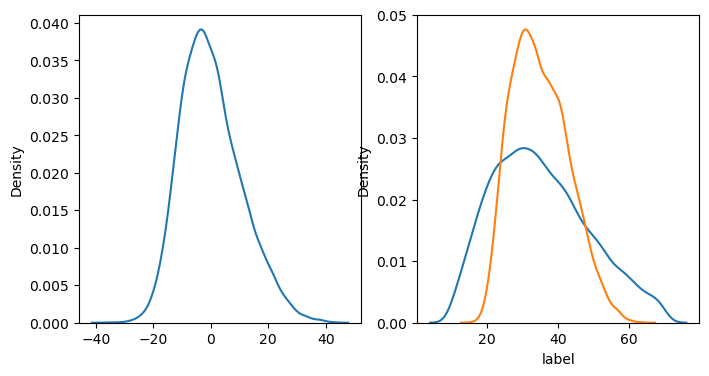

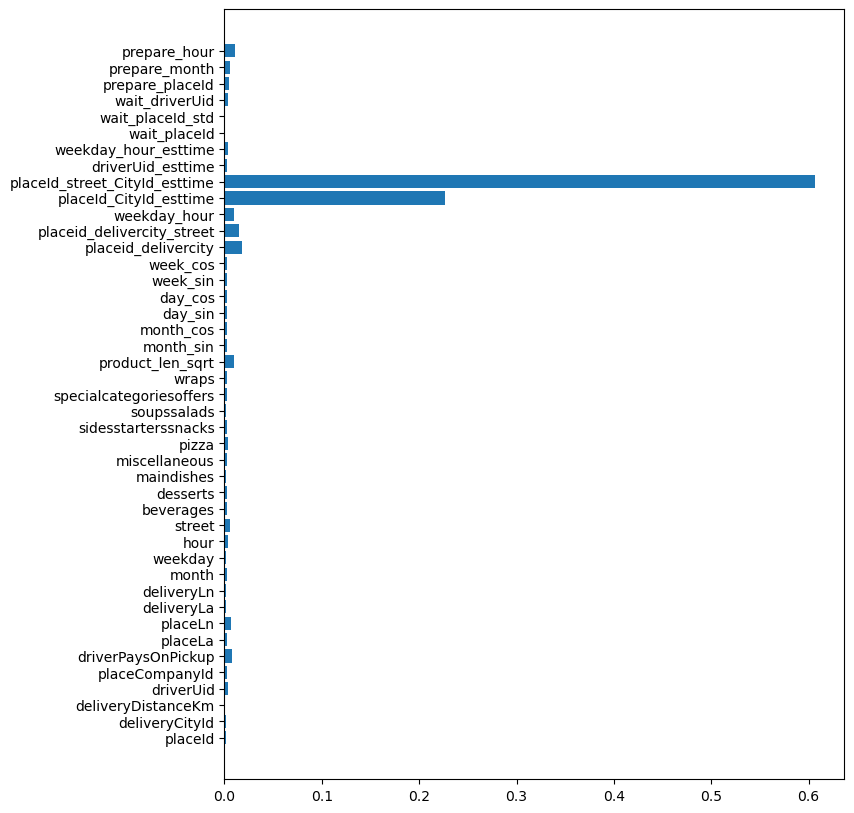

In [455]:
ensemble_train(d,y,pred_col="predict",model_name="xgb",cat_cols=[])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4430
[LightGBM] [Info] Number of data points in the train set: 9930, number of used features: 43
[LightGBM] [Info] Start training from score -0.013381
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.797408
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.61it/s]


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98445
[LightGBM] [Info] Number of data points in the train set: 9930, number of used features: 826
[0]	validation_0-rmse:0.95913
[100]	validation_0-rmse:0.78890
[200]	validation_0-rmse:0.79995
[254]	validation_0-rmse:0.80212
round0:	rmse = 0.783500265888483
[0]	validation_0-rmse:0.95879
[100]	validation_0-rmse:0.79420
[200]	validation_0-rmse:0.80024
[225]	validation_0-rmse:0.80218
round1:	rmse = 0.7861443267203362
[0]	validation_0-rmse:0.96708
[100]	validation_0-rmse:0.79112
[200]	validation_0-rmse:0.79761
[226]	validation_0-rmse:0.79812
round2:	rmse = 0.7834408669031239


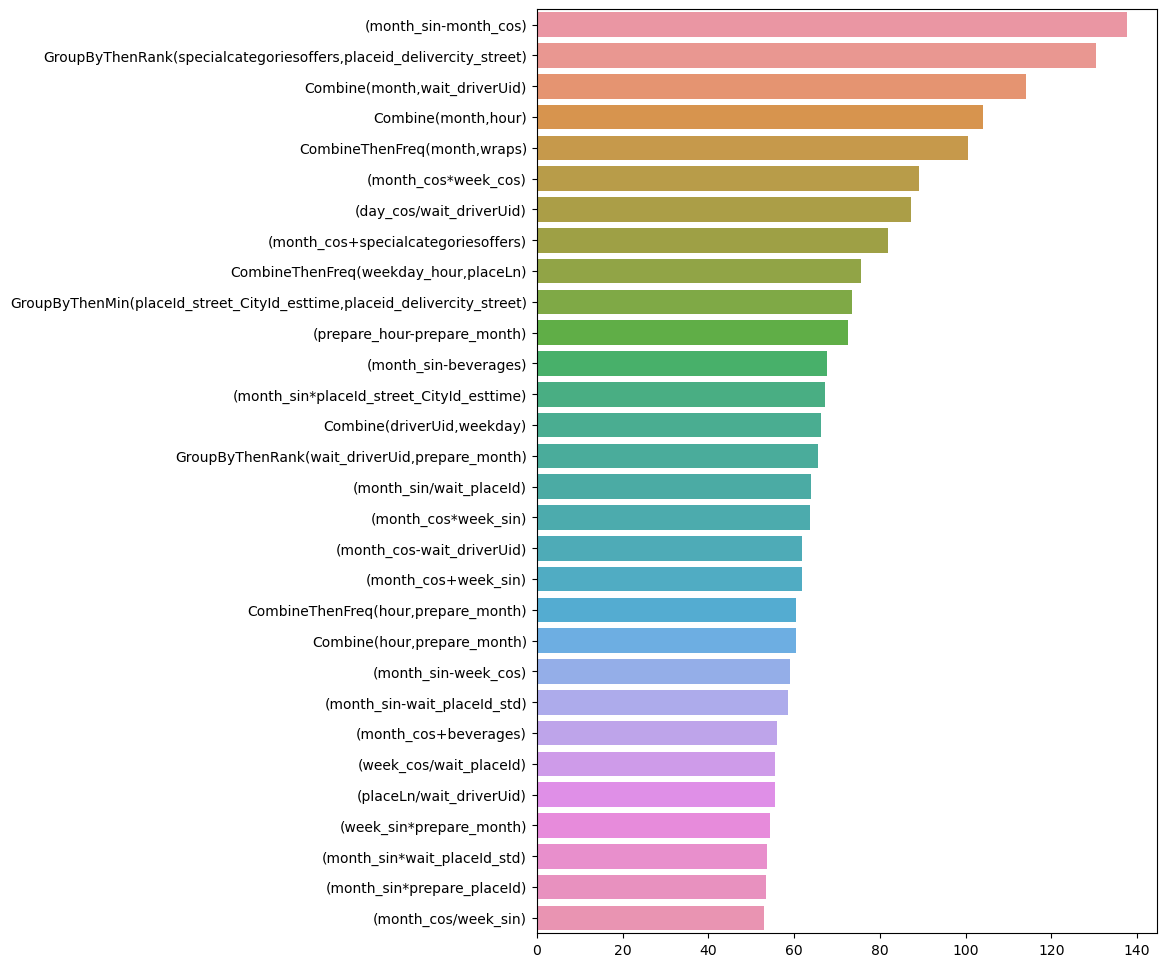

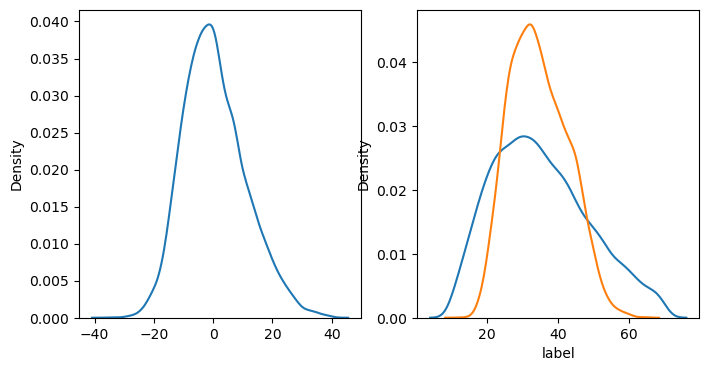

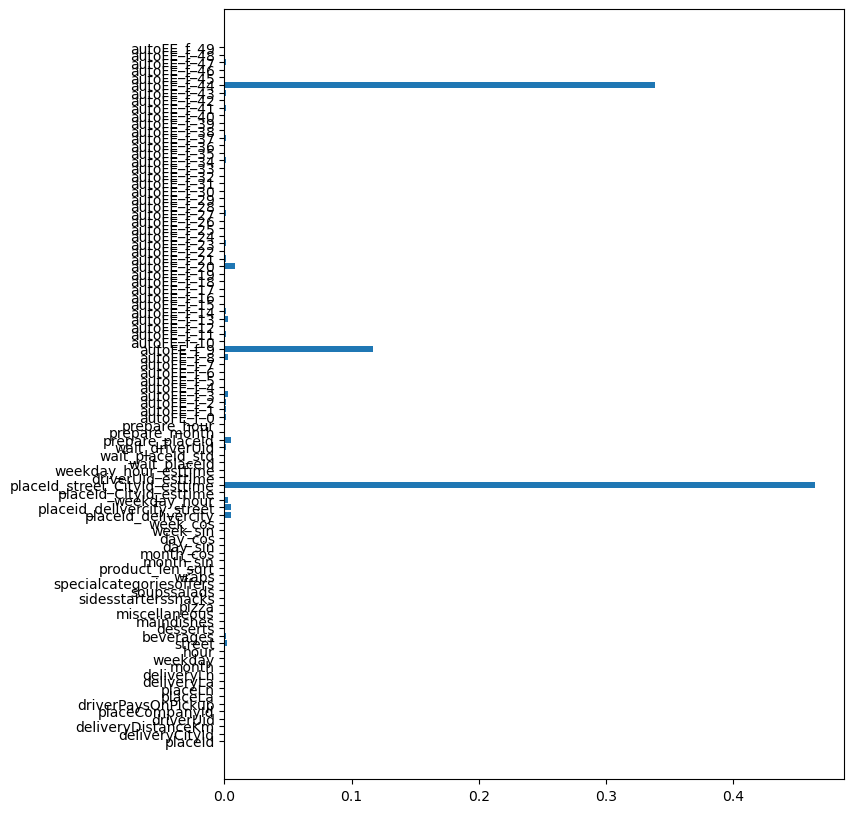

In [453]:
import openfe
from openfe import transform,tree_to_formula,OpenFE

of = OpenFE()
para = of.fit(data=d,label=y
      ,task="regression",metric="rmse",n_data_blocks=8,min_candidate_features=200,feature_boosting=True
             ,n_jobs=10,verbose=False)
import seaborn as sns

v = [[tree_to_formula(node),va] for node,va in of.new_features_scores_list[:30]]
plt.figure(figsize=(8,12))
sns.barplot(x=[va for _,va in v],y=[n for n,_ in v])
da,_ = transform(d,X_test=d[:10],new_features_list=para[0:50],n_jobs=10)

ensemble_train(da,y,model_name="xgb")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4479
[LightGBM] [Info] Number of data points in the train set: 9930, number of used features: 43
[LightGBM] [Info] Start training from score 0.002145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 0.735473	valid_0's l2: 0.540921
round0:	rmse = 0.7354732724297438
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [In

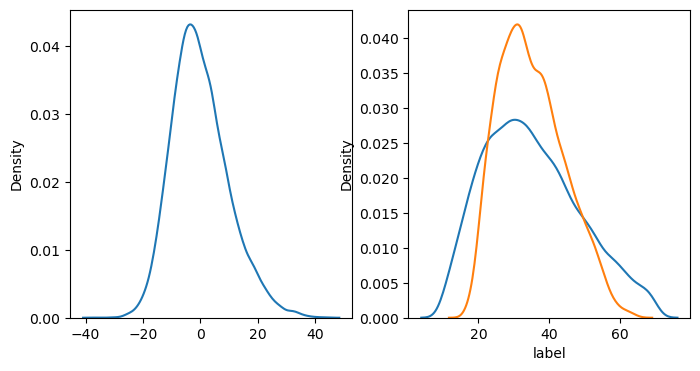

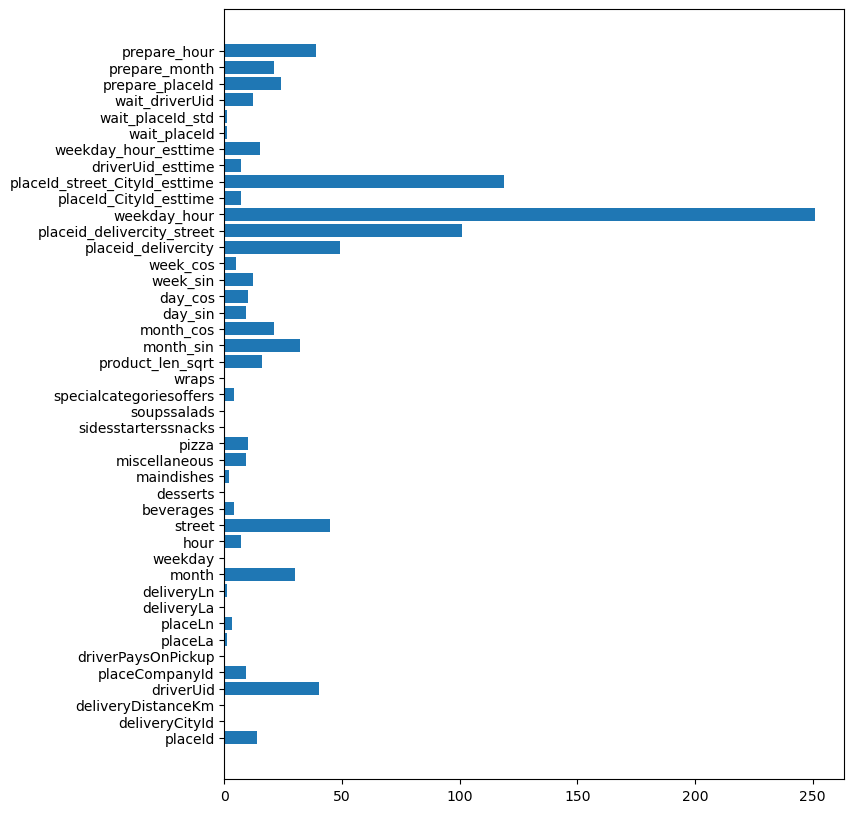

In [457]:
ensemble_train(d,y,model_name="lgb")

In [486]:
keep_columns = ['placeId', 'deliveryCityId',
        'deliveryDistanceKm',
        'driverUid', 'placeCompanyId',
       'placeLa', 'placeLn', 'deliveryLa', 'deliveryLn',
       'month', 'weekday', 'hour', 'street', 'beverages',
       'desserts', 'maindishes', 'miscellaneous', 'pizza',
       'sidesstarterssnacks', 'soupssalads', 'specialcategoriesoffers',
       'wraps', 'product_len_sqrt', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'week_sin', 'week_cos', 'placeid_delivercity',
       'placeid_delivercity_street', 'weekday_hour', 'placeId_CityId_esttime',
       'placeId_street_CityId_esttime', 'driverUid_esttime',
       'weekday_hour_esttime', 'wait_placeId', 'wait_placeId_std',
       'wait_driverUid', 'prepare_placeId', 'prepare_month', 'prepare_hour']
def keep(X,names):
    return X[names]

keep_transformer = FunctionTransformer(func = keep,kw_args={"names":keep_columns})
tabnet_pipe = Pipeline(steps = pipe.steps.copy())
tabnet_pipe.add_step("keep",keep_transformer)

cat_clos = ['placeId', 'deliveryCityId',"driverUid","placeCompanyId","month","weekday","hour","street","placeid_delivercity"
            ,"placeid_delivercity_street","weekday_hour"]
num_cols =["deliveryDistanceKm","placeLa","placeLn","deliveryLa","deliveryLn", 'placeId_CityId_esttime',
       'placeId_street_CityId_esttime', 'driverUid_esttime',
       'weekday_hour_esttime', 'wait_placeId', 'wait_placeId_std',
       'wait_driverUid', 'prepare_placeId', 'prepare_month', 'prepare_hour']
num_scaler = StandardScaler()
num_scaler.fit(data[num_cols])
cat_order = OrdinalEncoder()
cat_order.fit(data[cat_clos])

def cat_num_transfer(X,cats,nums,scaler,order):
    X[cats] = order.transform(X[cats])
    X[nums] = scaler.transform(X[nums])
    return X
cat_num_transformer = FunctionTransformer(func = cat_num_transfer,kw_args={"cats":cat_clos,"nums":num_cols,"scaler":num_scaler,"order":cat_order} )

tabnet_pipe.add_step("cat_num",cat_num_transformer)
d_tab = tabnet_pipe.transform(data)
d_tab
# ensemble_train(d_tab,y,model_name="tabnet",cat_cols=cat_clos)
# print(cat_clos)
# d.dtypes.values

,placeId,deliveryCityId,deliveryDistanceKm,driverUid,placeCompanyId,placeLa,placeLn,deliveryLa,deliveryLn,month,...,placeId_CityId_esttime,placeId_street_CityId_esttime,driverUid_esttime,weekday_hour_esttime,wait_placeId,wait_placeId_std,wait_driverUid,prepare_placeId,prepare_month,prepare_hour
openfe_index,,,,,,,,,,,,,,,,,,,,,
0,10.0,2.0,-0.709738,2.0,6.0,0.928284,11.631985,1.011938,6.778915,6.0,...,0.096348,0.291630,-0.258664,-0.652425,-2.364978,-0.768212,-2.029364,0.310664,-0.640467,-0.989089
1,5.0,0.0,0.401044,0.0,4.0,0.163055,-0.010073,0.547627,1.951314,6.0,...,0.364053,0.166906,0.486274,0.504044,-1.328463,-0.812796,1.281821,-0.132049,1.276488,0.679874
2,22.0,0.0,0.734278,0.0,20.0,0.193043,-0.225066,0.547627,1.951314,6.0,...,0.189881,-0.094591,0.837010,0.850984,-0.580258,-0.019599,1.281821,-0.698974,1.276488,0.679874
3,11.0,1.0,-0.709738,4.0,8.0,0.264181,-0.094851,-0.321306,0.034850,6.0,...,-0.084464,0.039898,-0.711132,-0.594819,-0.708937,-1.485749,1.056828,0.516501,0.519534,0.462988
4,11.0,7.0,-0.006243,4.0,8.0,0.264181,-0.094851,-0.010300,-1.484885,6.0,...,1.233293,1.290416,0.008641,0.179708,-0.708937,-1.485749,1.056828,0.516501,0.519534,0.462988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12408,2.0,15.0,1.363721,10.0,5.0,0.336200,-0.081576,2.534015,0.620627,0.0,...,1.169993,1.075608,1.400399,1.388569,-1.594755,-0.838696,0.661020,0.584453,1.312575,1.435680
12409,2.0,1.0,-0.709738,10.0,5.0,0.336200,-0.081576,-0.321306,0.034850,0.0,...,-0.890039,-0.873427,-0.714272,-0.689759,-1.594755,-0.838696,0.661020,0.104471,0.049915,0.242597
12410,22.0,1.0,-0.709738,3.0,20.0,0.193043,-0.225066,-0.321306,0.034850,0.0,...,-1.171945,-1.194359,-0.699025,-0.952033,-0.580258,-0.019599,-0.090266,-1.177216,-1.049294,-1.395735


groups [[13, 14, 15, 16, 17, 18, 19, 20], [23, 24], [27, 28], [25, 26]]
epoch 0  | loss: 6.2808  | val_0_unsup_loss_numpy: 4.001890182495117|  0:00:02s
epoch 30 | loss: 0.38973 | val_0_unsup_loss_numpy: 0.35231998562812805|  0:01:18s
Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_unsup_loss_numpy = 0.2893899977207184
epoch 0  | loss: 4.45641 | test_mse: 1.64195 |  0:00:01s
epoch 30 | loss: 0.41617 | test_mse: 0.64529 |  0:00:33s
epoch 60 | loss: 0.24122 | test_mse: 0.79267 |  0:01:09s

Early stopping occurred at epoch 62 with best_epoch = 12 and best_test_mse = 0.5598
round0:	rmse = 0.7481956715442099
epoch 0  | loss: 6.19666 | val_0_unsup_loss_numpy: 2.052309989929199|  0:00:02s
epoch 30 | loss: 0.39626 | val_0_unsup_loss_numpy: 0.3716999888420105|  0:01:24s
Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_unsup_loss_numpy = 0.2816300094127655
epoch 0  | loss: 7.85022 | test_mse: 2.89955 |  0:00:01s
epoch 30 |

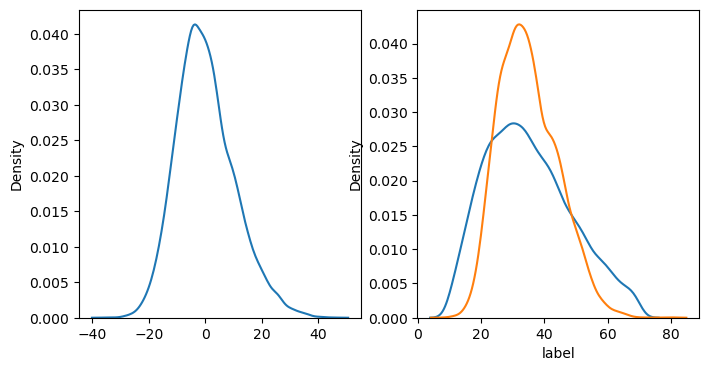

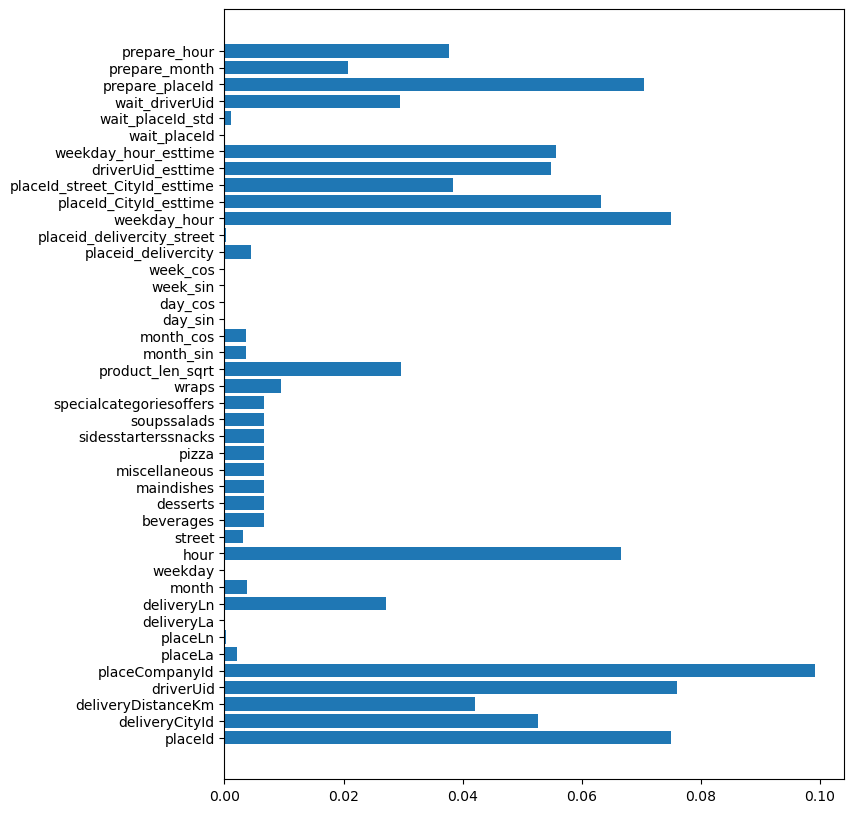

In [496]:
ensemble_train(d_tab,y,model_name="tabnet",cat_cols=cat_clos)

78/78 [==============================] - 0s 2ms/step
round0:	rmse = 0.7689083878292032
78/78 [==============================] - 0s 2ms/step
round1:	rmse = 0.771872236017304
78/78 [==============================] - 0s 2ms/step
round2:	rmse = 0.739403181372662
78/78 [==============================] - 0s 2ms/step
round3:	rmse = 0.7635687259566318
78/78 [==============================] - 0s 2ms/step
round4:	rmse = 0.7559900087795919
final rmse for all = 10.231732471308671
mean_absolute_error is 8.077996285998344
mean_squared_error is 10.231732471308671
precision for good is 0.6862160638040764
precision for medium is 0.8670748408926126


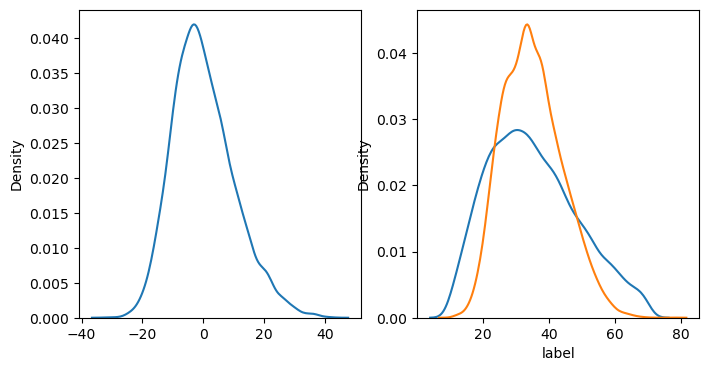

In [499]:
ensemble_train(d_tab,y,model_name="resnet",cat_cols=cat_clos)

31
cpu
[0, 1, 3, 4, 9, 10, 11, 12, 29, 30, 31]
x_num'shape (9930, 31)，X_cat's shape(9930, 11)
[0, 1, 3, 4, 9, 10, 11, 12, 29, 30, 31]
x_num'shape (2483, 31)，X_cat's shape(2483, 11)
Epoch 000 |Train mse=1.0266 Validation mse=1.0174
Epoch 020 |Train mse=0.9944 Validation mse=0.9892
Epoch 040 |Train mse=0.9920 Validation mse=0.9902
Epoch 060 |Train mse=0.9923 Validation mse=0.9904
epoch is 26, Best score is -0.9874577522277832
[0, 1, 3, 4, 9, 10, 11, 12, 29, 30, 31]
x_num'shape (2483, 31)，X_cat's shape(2483, 11)
round0:	rmse = 0.9905508716778751
31
cpu
[0, 1, 3, 4, 9, 10, 11, 12, 29, 30, 31]
x_num'shape (9930, 31)，X_cat's shape(9930, 11)
[0, 1, 3, 4, 9, 10, 11, 12, 29, 30, 31]
x_num'shape (2483, 31)，X_cat's shape(2483, 11)
Epoch 000 |Train mse=1.0280 Validation mse=1.0269
Epoch 020 |Train mse=0.9935 Validation mse=0.9883
Epoch 040 |Train mse=0.9935 Validation mse=0.9877
Epoch 060 |Train mse=0.9935 Validation mse=0.9877
epoch is 25, Best score is -0.986640989780426
[0, 1, 3, 4, 9, 10, 11, 

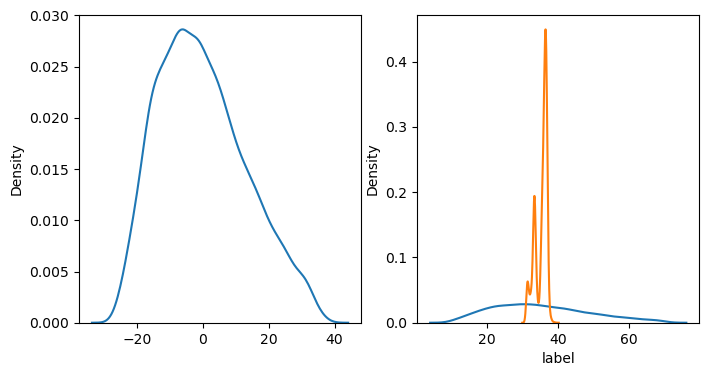

In [515]:
from rtdl import FTTransformer as ft
import zero
import torch.nn.functional as F
import torchmetrics as tm
class FT_Transformer:
    regression = "regression"
    classification = "classification"
    def __init__(self,n_num_features,cat_idxs = [],cat_dims = [],n_feature_size=16,n_blocks=3
                     ,kv_compression_ratio=None,kv_compression_sharing=None
                 ,ffn_d_hidden = None,ffn_dropout = 0.1,residual_dropout=0.0
                   ,attention_dropout = 0.0 ,task_type = "regression"  # classification
                     ,class_number = 2,device="auto"):
        assert n_feature_size%8==0,"n_feature_size must be times of 8, like 16,32,.."
        assert task_type in [FT_Transformer.regression,FT_Transformer.classification],"task_type = regression or classification"
        assert device in ["cuda","cpu","auto"]," device = cuda or cpu or auto"
        if(device == "auto"):
            device = "cuda" if torch.cuda.is_available() else "cpu"

        if(ffn_d_hidden==None):
            ffn_d_hidden = n_feature_size
        self.out_size = 1 if(task_type==FT_Transformer.regression or class_number==2) else class_number
        self.model:rtdl.FTTransformer = ft.make_baseline(n_num_features=n_num_features,cat_cardinalities=cat_dims
                                      ,n_blocks = n_blocks,ffn_d_hidden=ffn_d_hidden,ffn_dropout=ffn_dropout
                                      ,residual_dropout=residual_dropout,attention_dropout = attention_dropout
                                     ,d_token=n_feature_size,kv_compression_ratio=kv_compression_ratio
                                     ,kv_compression_sharing=kv_compression_sharing
                                     ,d_out = self.out_size)
#         self.model = ft.make_default(
#             n_num_features=n_num_features,
#             cat_cardinalities=cat_dims,
#             last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
#             d_out=1,
#         )

        self.model.to(device)
        self.task_type = task_type
        self.classNumber = class_number
        self.cat_idxs=cat_idxs
        self.device = device
        print(self.device)
        self.optimizer = self.model.make_default_optimizer()
#         self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.0002)
        if(self.task_type==FT_Transformer.regression):
            self.loss_fun = F.mse_loss
        elif(self.task_type==FT_Transformer.classification):
            if(self.out_size==1):
                self.loss_fun = F.binary_cross_entropy_with_logits
            else:
                self.loss_fun = F.cross_entropy

    def handle_data(self,X,y):  
        if(isinstance(X,(pd.DataFrame,pd.Series))):
            X = X.values
        if(y is not None and isinstance(y,pd.Series)):
            y=y.values      
        if(self.cat_idxs):
            x_col_indx=set(range(np.shape(X)[1]))
            print(self.cat_idxs)
            assert set(self.cat_idxs).issubset(x_col_indx),f"cat_idx out of range of X dims, difference is {self.cat_idxs.difference(x_col_indx)}"
            X_cat = X[:,self.cat_idxs]
            X_num = X[:,list(x_col_indx.difference(self.cat_idxs))]
            print(f"x_num'shape {X_num.shape}，X_cat's shape{X_cat.shape}")
            X_cat = torch.Tensor(X_cat).to(self.device).to(torch.int)
            X_num = torch.Tensor(X_num).to(self.device)
        else:
            X_num = torch.Tensor(X).to(self.device)
            X_cat = None
        if(y is not None):
            y = torch.Tensor(y).to(self.device)

        return X_num,X_cat,y
    
    def fit(self, X,y,eval_set=None, eval_metric=None, max_epochs=1000, vobosity = 1, patience=50,batch_size=256):
        assert eval_metric!=None,"must set eval_metric"
        X_num,X_cat,y = self.handle_data(X,y)
        if(eval_set):
            X_val_num,X_val_cat,val_y = self.handle_data(*eval_set)
        train_loader = zero.data.IndexLoader(len(X), batch_size, device=self.device)
        progress = zero.ProgressTracker(patience=patience)
        best_epoch = 0
        score_list = []
        for epoch_id in range(max_epochs):
            for batch_idx in train_loader:
                self.model.train()
                self.optimizer.zero_grad()
                num_batch = X_num[batch_idx]
                cat_batch = X_cat[batch_idx] if(X_cat is not None) else None
                y_batch = y[batch_idx]
                self.loss_fun(self.model(num_batch,cat_batch), y_batch).backward()
                self.optimizer.step()
            if(eval_set and eval_metric):
#                 print(val_y.shape)
                metric_value = self.evaluate(eval_metric,X_val_num,X_val_cat,val_y)
                train_metric_value = self.evaluate(eval_metric,X_num,X_cat,y)
                score_list.append(metric_value)
                if(epoch_id%vobosity==0):
                    print(f'Epoch {epoch_id:03d} |Train {eval_metric}={train_metric_value:.4f} Validation {eval_metric}={metric_value:.4f}')
                if(self.task_type==FT_Transformer.regression):
                    metric_value = -metric_value
                progress.update(metric_value)
                if(progress.success):
                    best_epoch = epoch_id
                if progress.fail:
                    print(f"epoch is {best_epoch}, Best score is {progress.best_score}")
                    break            
        return metric_value
    
    @torch.no_grad()    
    def evaluate(self,metric,X_val_num,X_val_cat,val_y):
        self.model.eval()
        result = self.model(X_val_num,X_val_cat)
        if(self.task_type==FT_Transformer.regression):
            if(metric=='mse'):
                result = torch.squeeze(result,-1)
                metric_fun = tm.MeanSquaredError(squared=False).to(self.device)
                return metric_fun(result,val_y)
            elif(callable(metric)):
                return metric.to(self.device)(val_y,result)
            else:
                raise Exception("metric is 'mse' or callable")
        else:
            if(self.class_number==2):
                result= F.sigmoid(result)
            else:
                result =F.softmax(result,dim=-1)
                
            if(metric=='accuracy'):
                return tm.Accuracy(num_classes=self.class_number).to(self.device)(val_y,result)
            elif(metric=="f1"):
                return tm.F1Score(num_classes=self.class_number).to(self.device)(val_y,result)
            elif(callable(metric)):
                return metric.to(device)(val_y,result)
            else:
                raise Exception("metric is 'accuracy,f1' or callable")        
#     @torch.no_grad()
    def predict(self,input):
        self.model.eval()
        with torch.no_grad():
            X_num,X_cat,_= self.handle_data(input,None)
            result = self.model(X_num,X_cat)
            return result.cpu().numpy()
            
        
# model = ft.make_default(n_num_features=8,cat_cardinalities=[2,3],d_out=1)
# model
#FT_Transformer(6,[3,3],192,2,task_type=FT_Transformer.classification,class_number=3).model
torch.cuda.empty_cache()
gc.collect()
ensemble_train(d_tab,y,model_name="ft",cat_cols=cat_clos)

### end to end model

In [525]:

model:LGBMRegressor = LGBMRegressor(n_estimators=1000,random_state=42,colsample_bytree =0.8
             ,learning_rate = 0.1,subsample=0.8,n_jobs=10,num_leaves=20)
model.fit(x_train, y_train,eval_set=[(x_test,y_test)]
          ,eval_metric="rmse"
        ,callbacks=[lightgbm.early_stopping(50, verbose=100)])

xgboost_pipe.add_step("model",model)
online_data = test_data.sample(100)
pred = xgboost_pipe.predict(online_data)

y_scaler.inverse_transform(np.reshape(pred,[-1,1]))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4441
[LightGBM] [Info] Number of data points in the train set: 9309, number of used features: 43
[LightGBM] [Info] Start training from score 0.000798
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 0.728517	valid_0's l2: 0.530738
placeId
deliveryCityId
driverUid
placeCompanyId
month
weekday
hour
street
placeid_delivercity
placeid_delivercity_street
weekday_hour


array([[28.34359919],
       [31.1833903 ],
       [37.14399812],
       [22.76493172],
       [59.2912703 ],
       [39.7973623 ],
       [23.95406778],
       [56.43865235],
       [34.77060601],
       [28.72269975],
       [35.89542766],
       [46.56272582],
       [33.11306327],
       [41.57884257],
       [27.83535338],
       [38.47274541],
       [48.02505563],
       [33.57663289],
       [26.73123051],
       [61.24633202],
       [33.06990956],
       [23.32138458],
       [36.29122994],
       [23.97181441],
       [38.50901935],
       [29.22804806],
       [29.52926866],
       [35.61807608],
       [33.30825072],
       [28.83983312],
       [36.68689052],
       [34.25099214],
       [25.16159769],
       [38.95191058],
       [30.01900064],
       [35.51276987],
       [40.72043156],
       [38.53522549],
       [23.05178559],
       [32.41511784],
       [46.97934099],
       [43.54270385],
       [28.7106395 ],
       [43.49770503],
       [32.84305591],
       [37